## <div class="alert alert-info"><h1>Imports</h1></div>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import traceback
import miceforest as mf
import time
from docx import Document
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import HTML
from openpyxl import Workbook

#Start a timer to check the execution time of the notebook.
start_time = time.time()

## <div class="alert alert-info"><h4>Putting all function definitions at the top</h4></div>

In [2]:
# Function to reduce memory usage of a DataFrame
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:  # Exclude strings and categorical columns
            c_min = df[col].min()
            c_max = df[col].max()

            try:
                if str(col_type).startswith('int'):
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)

                elif str(col_type).startswith('float'):
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

            except ValueError as e:
                print(f"Warning: {e} for column {col}")
                df[col] = df[col].astype(np.float64)  # Handle large values gracefully

    return df

In [3]:
def merge_with_zip_data(df,zip_data):
    """
    Merges a DataFrame with zip code data, cleaning and preparing the zip codes.
    Assumes the zip code column is named 'zip' in both DataFrames.

    Args:
        df: The DataFrame to merge with zip data.
        zip_data: The DataFrame containing zip code information (city, state).

    Returns:
        The merged DataFrame, or None if an error occurs.
    """

    # Merge, keeping all rows from df and adding city/state only where ZIPs match
    merged_df = df.merge(zip_data[['zip', 'city', 'state']], on='zip', how='left')

    # Handle potential duplicate columns
    # if 'city_x' in merged_df.columns:
    #   merged_df = merged_df.drop(columns=['city_x']).rename(columns={'city_y': 'city'})

    # if 'state_x' in merged_df.columns:
       # merged_df = merged_df.drop(columns=['state_x']).rename(columns={'state_y': 'state'})

    return merged_df
 

In [4]:
def merge_dataframes(df1, df2, common_cols, how='outer'):
    """Merges two health data DataFrames on specified common columns, 
       handling inconsistencies and potential duplicates.
    """

    # Merge (using cleaned and standardized columns)
    merged_df = pd.merge(df1, df2, on=common_cols, how=how)

    # Remove duplicate columns (keeping the first occurrence)
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated(keep='first')]

    return merged_df

In [5]:
# Function to find closest zip code (+1 or -1)
def find_closest_zip(zip_code, df):
    # Ensure zip_code is a valid number (convert to numeric and coerce invalid to NaN)
    zip_code_int = pd.to_numeric(zip_code, errors='coerce')  # Convert to numeric, coerce invalid to NaN
    
    if pd.isna(zip_code_int):  # If zip_code is invalid, return None
        return None
    
    # Check for zip +1 and zip -1
    zip_plus = str(zip_code_int + 1)
    zip_minus = str(zip_code_int - 1)
    
    # Find zip codes in zip_data that match +1 or -1
    match_plus = df[df['zip'] == zip_plus]
    match_minus = df[df['zip'] == zip_minus]
    
    # Return the first match found (either +1 or -1, depending on which exists)
    if not match_plus.empty:
        return match_plus[['city', 'state']].iloc[0]
    elif not match_minus.empty:
        return match_minus[['city', 'state']].iloc[0]
    else:
        return None



In [6]:
def merge_with_occupation_data(df):
    # Select only numeric columns and the occupation column from occupation_data
    numeric_columns = occupation_data.select_dtypes(include='number').columns
    required_columns = ['state', 'occupation'] + list(numeric_columns)
    
    occupation_data_filtered = occupation_data[required_columns]


    # Aggregate the filtered occupation_data by state and occupation
    aggregated_occupation_data = occupation_data_filtered.groupby(['state', 'occupation']).agg({
        col: 'sum' for col in numeric_columns
    }).reset_index()

    df['state'] = df['state'].str.strip()
    aggregated_occupation_data['state'] = aggregated_occupation_data['state'].str.strip()
    
 
    # Merge the input DataFrame with aggregated occupation_data
    merged_df = pd.merge(df, aggregated_occupation_data, on='state', how='left')

    
    # Drop the city and state columns from the resulting DataFrame if needed
    merged_df = merged_df.drop(columns=['medicare_prov_num', 'city', 'zip'], errors='ignore')

    return merged_df

In [7]:
def plot_occupation_distribution(df, hue='population'):
    """Plots occupation distribution with population data or a custom hue."""
    try:
        df['state'] = df['state'].astype(str).str.strip()
        occ_counts = df.groupby('state')['occupation'].nunique().reset_index()
        occ_counts.rename(columns={'occupation': 'occupation_count'}, inplace=True)

        # --- Population Handling ---
        if 'population' in df.columns:
            df['population'] = pd.to_numeric(df['population'], errors='coerce')  # Convert to numeric

            if 'area' in df.columns:
                pop_area_unique = df[['state', 'population', 'area']].drop_duplicates(subset='state')
            else:
                pop_area_unique = df[['state', 'population']].drop_duplicates(subset='state')

            occ_counts = occ_counts.merge(pop_area_unique, on='state', how='left')

        # Ensure the selected hue column exists, else fallback to 'occupation_count'
        if hue not in occ_counts.columns:
            print(f"Warning: '{hue}' not found in data. Falling back to 'occupation_count'.")
            hue = 'occupation_count'

        occ_counts['state_numeric'] = occ_counts['state'].astype('category').cat.codes
        occ_counts['state_jitter'] = occ_counts['state_numeric'] + np.random.uniform(-0.2, 0.2, size=len(occ_counts))

        plt.figure(figsize=(12, 6))

        scatter = sns.scatterplot(
            data=occ_counts,
            x='state_jitter',
            y='occupation_count',
            size='population' if 'population' in occ_counts.columns else None,
            hue=hue,
            sizes=(50, 1000),
            palette='viridis',
            hue_norm=(occ_counts[hue].min(), occ_counts[hue].max()) if hue in occ_counts.columns else None,
            legend='full'
        )

        # Legend Handling
        if 'population' in occ_counts.columns:
            population_for_legend = occ_counts['population'].dropna()
            if not population_for_legend.empty:
                pop_min = population_for_legend.min()
                pop_max = population_for_legend.max()
                pop_threshold = np.percentile(population_for_legend, 75)
                top_pop_values = np.linspace(pop_threshold, pop_max, num=5)

                def pop_to_size(pop):
                    return np.interp(pop, [pop_min, pop_max], [50, 1000]) if pop_max - pop_min >= 1e-6 else 100

                dummy_handles = []
                cmap = sns.color_palette("viridis", as_cmap=True)
                for pop_val in top_pop_values:
                    size_val = pop_to_size(pop_val)
                    dummy = plt.scatter([], [], s=size_val, color=cmap(0.5))
                    dummy_handles.append(dummy)

                if top_pop_values.size > 0:
                    plt.legend(
                        dummy_handles,
                        [f"{int(val):,}" for val in top_pop_values],
                        title="Population (Top 25%)",
                        bbox_to_anchor=(1.05, 1),
                        loc=2,
                        markerscale=0.5,
                        labelspacing=1.5,
                        handletextpad=1.0,
                        borderaxespad=0.5
                    )

        plt.xticks(ticks=occ_counts['state_numeric'], labels=occ_counts['state'], rotation=90)
        plt.xlabel("State")
        plt.ylabel("Number of Unique Occupations")
        plt.title(f"Unique Occupations per State (Hue: {hue.capitalize()})")
        plt.grid(True, linestyle="--", alpha=0.5)

        plt.show()

    except Exception as e:
        print(f"Error in plotting: {type(e).__name__}: {e}")


In [8]:
def plot_regression(x_col, y_col, data, title, line_color='red'):
    """Plots a regression line with customizable line color."""
    
    plt.figure(figsize=(10, 6))
    sns.regplot(data=data, x=x_col, y=y_col, scatter_kws={'alpha': 0.5}, line_kws={'color': line_color}) 
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(y_col.replace('_', ' ').title())
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()



In [9]:
# Process Data Function
def process_data(health_df, cdc_df):
    # Define the state-to-region mapping
    state_to_region = {
        'connecticut': 'northeast', 'maine': 'northeast', 'massachusetts': 'northeast', 'new hampshire': 'northeast', 
        'rhode island': 'northeast', 'vermont': 'northeast', 'new jersey': 'northeast', 'new york': 'northeast', 
        'pennsylvania': 'northeast', 'delaware': 'south', 'district of columbia': 'south', 'florida': 'south', 
        'georgia': 'south', 'maryland': 'south', 'north carolina': 'south', 'south carolina': 'south', 'virginia': 'south', 
        'west virginia': 'south', 'alabama': 'south', 'kentucky': 'south', 'mississippi': 'south', 'tennessee': 'south',
        'arkansas': 'south', 'louisiana': 'south', 'oklahoma': 'south', 'texas': 'south', 'illinois': 'midwest', 
        'indiana': 'midwest', 'michigan': 'midwest', 'ohio': 'midwest', 'wisconsin': 'midwest', 'iowa': 'midwest', 
        'kansas': 'midwest', 'minnesota': 'midwest', 'missouri': 'midwest', 'nebraska': 'midwest', 'north dakota': 'midwest', 
        'south dakota': 'midwest', 'arizona': 'west', 'colorado': 'west', 'idaho': 'west', 'montana': 'west', 'nevada': 'west', 
        'new mexico': 'west', 'utah': 'west', 'wyoming': 'west', 'alaska': 'west', 'california': 'west', 'hawaii': 'west', 
        'oregon': 'west', 'washington': 'west'
    }

    # Standardize column names
    health_df.rename(columns=lambda x: x.strip().lower(), inplace=True)
    cdc_df.rename(columns=lambda x: x.strip().lower(), inplace=True)

    # Ensure 'state' column is standardized before mapping
    health_df['state'] = health_df['state'].astype(str).str.strip().str.lower()

    # Map states to correct regions
    health_df['region'] = health_df['state'].map(state_to_region)

    # Debug: Check if mapping worked correctly
    print("Unique regions in health_df after mapping:", health_df['region'].unique())

    # Drop unnecessary columns before aggregation
    columns_to_drop = ['zip']
    health_df.drop(columns=[col for col in columns_to_drop if col in health_df.columns], inplace=True)

    # Auto-detect numeric columns for aggregation
    numeric_columns = health_df.select_dtypes(include=['number']).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col not in ['region', 'state', 'city']]

    # ---- Aggregate at City Level (Keep Correct Region) ----
    city_agg = health_df.groupby(['region', 'state', 'city'])[numeric_columns].sum().reset_index()
    city_agg['aggregation_level'] = 'city'

    # ---- Use only city level aggregation ----
    health_agg = city_agg

    # Ensure `region` Format is Consistent Before Merging
    health_agg['region'] = health_agg['region'].astype(str).str.strip().str.lower()
    cdc_df['region'] = cdc_df['region'].astype(str).str.strip().str.lower()

    # Define correct region mapping
    region_mapping = {
        '1': 'northeast',
        '2': 'midwest',
        '3': 'south',
        '4': 'west'
    }

    # Apply the mapping correctly
    cdc_df['region'] = cdc_df['region'].map(region_mapping)

    # Check for NaN values after mapping
    print("Unique regions in cdc_df after mapping:", cdc_df['region'].unique())
    print("Unique regions in health_agg after mapping:", health_agg['region'].unique())

    # Check for NaN values in the `region` column
    print("NaN values in region column before merge:", health_agg['region'].isna().sum())

    # Reduce memory usage of dataframes
    health_agg = reduce_memory_usage(health_agg)
    cdc_df = reduce_memory_usage(cdc_df)

    # Merge with `cdc_df` and specify suffixes to resolve duplicate column names
    merged_df = health_agg.merge(cdc_df, on='region', how='left', suffixes=('_health', '_cdc'))

    # Check for NaN values in the merged dataframe
    print("NaN values in merged dataframe:", merged_df.isna().sum())

    # Call the garbage collector
    gc.collect()

    return merged_df

In [10]:
def find_dataframes():
    """Finds all pandas DataFrames in the current scope."""
    dfs = []
    for name, obj in globals().items():  # or locals() for local scope
        if isinstance(obj, pd.DataFrame):
            dfs.append((name, obj))
    return dfs

In [11]:
def remove_old_dataframes(keep_last=3):
    """Removes all DataFrames except the last 'keep_last' created."""
    dfs = []
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame):
            dfs.append((name, obj))

    if len(dfs) > keep_last:
        to_remove = dfs[:-keep_last]  # Get all but the last 'keep_last'
        names_to_delete = [name for name, _ in to_remove] # collect names.

        for name in names_to_delete: # delete after the first loop.
            del globals()[name]
        print(f"Removed {len(names_to_delete)} DataFrames.")
    else:
        print("No DataFrames removed.")

In [12]:
def plot_pca_scatter(x, y, quartiles, price, state, pc_var, title="States Summary PCA"):
    """
    Plots a PCA scatter plot with points sized by 'price' and labeled by 'quartiles'.

    Parameters:
    - x (array-like): First principal component values.
    - y (array-like): Second principal component values.
    - quartiles (pd.Series or array-like): Categorical values to color code points.
    - price (array-like): Determines point sizes.
    - state (array-like): State labels for annotation.
    - pc_var (float): Percentage of variance explained by the first two components.
    - title (str): Title of the plot (default: 'Medical Access States Summary PCA').
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot with different quartiles
    for q in quartiles.cat.categories:
        im = quartiles == q
        ax.scatter(x[im], y[im], s=price[im], label=q)

    # Labels and title
    ax.set_xlabel('First Component')
    ax.set_ylabel('Second Component')
    ax.set_title(f'{title}, {pc_var:.1f}% Variance Explained')
    
    # Add legend
    plt.legend()

    # Annotate points with state names
    for s, x_coord, y_coord in zip(state, x, y):
        plt.annotate(s, (x_coord, y_coord))

    plt.show()


In [13]:
# define useful function to create scatterplots of access against desired columns
def scatterplots(df,columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'access', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='Medical Access')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [14]:
def fill_missing_city_state(df):
    """
    Optimized function to fill missing city and state for missing ZIP codes in bulk.

    Args:
        df (pd.DataFrame): The DataFrame where city/state are missing.

    Returns:
        pd.DataFrame: Updated DataFrame with missing city/state filled.
    """
    # Extract rows where city and state are missing
    missing_rows = df[df['city'].isna() & df['state'].isna()].copy()
    
    if missing_rows.empty:
        print("No missing city/state values to fill.")
        return df  # No missing values, return the original df
    
    # Convert ZIP codes to string format
    missing_rows['zip'] = missing_rows['zip'].astype(str).str.strip().str.zfill(5)
    df['zip'] = df['zip'].astype(str).str.strip().str.zfill(5)

    # Store missing ZIPs in a set for quick lookup
    missing_zips = set(missing_rows['zip'])

    # Dictionary to store found city/state values
    zip_city_state_map = {}

    # Find closest match for each missing ZIP
    for zip_code in missing_zips:
        match = find_closest_zip(zip_code, df)  # Find nearest ZIP match within df
        if match is not None:
            zip_city_state_map[zip_code] = (match['city'], match['state'])

    # Apply found values back to the missing rows
    df.loc[df['zip'].isin(zip_city_state_map.keys()), ['city', 'state']] = df['zip'].map(zip_city_state_map).apply(pd.Series)

    print(f"Filled missing city/state values for {len(zip_city_state_map)} ZIP codes.")

    return df


<div class="alert alert-info"><h2>Load the Occupation by State, Gender, and Race Data</h2></div>

In [15]:
# the supplied CSV data file is in the data directory
occupation_data = pd.read_csv('../data/occupation_by_state_gender_race.csv')

In [16]:
#Only do this if memory becomes an issue. Deleting unused dataframes should be better. 
#occupation_data = reduce_memory_usage(occupation_data)

In [17]:
occupation_data.T.head(7)

,0,1,2,3,4,5,6,7,8,9,...,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831
area_health_resource_files_release_year,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,...,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019,ACS 5-Year 2015-2019
occupation_name,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,Advanced Practice Registered Nurses (excl. Cli...,...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...,Veterinary Assistants & Laboratory Animal Care...
geography_name,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin
hispanic,NaN,NaN,478.0,NaN,1364.0,98.0,106.0,NaN,NaN,2154.0,...,NaN,NaN,120.0,1206.0,NaN,NaN,121.0,287.0,NaN,NaN
white,3989.0,643.0,2998.0,1655.0,7661.0,2845.0,2233.0,540.0,522.0,9377.0,...,542.0,195.0,1139.0,1919.0,161.0,250.0,2049.0,2123.0,385.0,1401.0
black,418.0,NaN,125.0,146.0,826.0,NaN,94.0,142.0,181.0,1321.0,...,NaN,NaN,NaN,233.0,NaN,NaN,140.0,NaN,NaN,NaN
asian,81.0,NaN,193.0,NaN,3169.0,NaN,97.0,52.0,77.0,706.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-info"><strong>All NaN to be replaced with 0 for race.</strong><br>
Assumption is that NaN is the same as unknown and 0 will be unknown for us<br>
When shortening race columns, the associated % columns were not shortened.<br>
The code below takes care of that.</div>

In [18]:
columns_to_fill = ['hispanic', 'white', 'black', 'asian', 'pacific', 'indigenous', 'other']
occupation_data.fillna({col: 0 for col in columns_to_fill}, inplace=True)

rename_mapping = {}

for col in columns_to_fill:
    old_base_name = ""
    if col == 'white':
        old_base_name = 'white'
    elif col == 'asian':
        old_base_name = 'asian'
    elif col == 'hispanic':
      old_base_name = 'hispanic-latino'
    elif col == 'black':
      old_base_name = 'black-african_american'
    elif col == 'pacific':
      old_base_name = 'native_hawaiian-other_pacific_islander'
    elif col == 'indigenous':
      old_base_name = 'american_indian-alaska_native'
    elif col == 'other':
      old_base_name = 'other-multiple_races'
    
    if old_base_name != "":
      rename_mapping[old_base_name] = col
      rename_mapping[old_base_name + '_%'] = col + '_%'



occupation_data.rename(columns=rename_mapping, inplace=True)
occupation_data.head()

,area_health_resource_files_release_year,occupation_name,geography_name,hispanic,white,black,asian,pacific,indigenous,other,...,30_to_39_%,40_to_49_%,50_to_59_%,60+_%,male_%,female_%,missing-suppressed_raceethnicity_data_comment,missing-suppressed_age_data_comment,missing-suppressed_gender_data_comment,hrsa_data_warehouse_processing_date
0,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Alabama,0.0,3989.0,418.0,81.0,0.0,0.0,0.0,...,34.294,24.747,21.755,7.567,18.918,81.082,Hispanic: Supressed; Native Hawaiian/ Pacific ...,NaN,NaN,2022/03/21
1,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Alaska,0.0,643.0,0.0,0.0,0.0,0.0,0.0,...,44.706,30.065,NaN,17.124,NaN,98.954,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Less than 30 Years Old: Supressed; 50 to 59 Ye...,Male: Supressed,2022/03/21
2,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Arizona,478.0,2998.0,125.0,193.0,0.0,0.0,122.0,...,29.833,24.595,24.949,18.219,19.104,80.896,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21
3,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,Arkansas,0.0,1655.0,146.0,0.0,0.0,0.0,0.0,...,33.045,25.690,24.013,13.196,18.983,81.017,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,NaN,NaN,2022/03/21
4,ACS 5-Year 2015-2019,Advanced Practice Registered Nurses (excl. Cli...,California,1364.0,7661.0,826.0,3169.0,0.0,0.0,469.0,...,30.619,22.077,21.553,19.068,15.136,84.864,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,2022/03/21


<div class="alert alert-info"><strong>The first column appears to be the same across all rows. Let's check that. </strong></div>

<div class="alert alert-info"><strong>The first column is the same across all 1832 rows. We need to drop it. </strong></div>

In [19]:
occupation_data = occupation_data.drop('area_health_resource_files_release_year',axis=1)

In [20]:
occupation_data.sample(3)

,occupation_name,geography_name,hispanic,white,black,asian,pacific,indigenous,other,less_than_30,...,30_to_39_%,40_to_49_%,50_to_59_%,60+_%,male_%,female_%,missing-suppressed_raceethnicity_data_comment,missing-suppressed_age_data_comment,missing-suppressed_gender_data_comment,hrsa_data_warehouse_processing_date
1075,Personal Care Aides,Kentucky,270.0,11715.0,1677.0,0.0,0.0,0.0,271.0,4570.0,...,18.090,15.380,18.647,15.208,16.774,83.226,Asian (Non-Hispanic): Supressed; Native Hawaii...,NaN,NaN,2022/03/21
1669,Social Workers,Pennsylvania,1495.0,20850.0,5948.0,422.0,0.0,0.0,408.0,6428.0,...,30.260,21.555,14.970,11.158,20.354,79.646,Native Hawaiian/ Pacific Islander: [No Data]; ...,NaN,NaN,2022/03/21
794,Medical Transcriptionists,New York,173.0,1394.0,247.0,376.0,0.0,0.0,0.0,1191.0,...,10.183,9.954,12.374,13.105,17.900,82.100,Native Hawaiian/ Pacific Islander: [No Data]; ...,NaN,NaN,2022/03/21


In [21]:
#Check for the last column that appears to have the same value across all rows.
try:
    unique_values = occupation_data['hrsa_data_warehouse_processing_date'].unique()
    display(unique_values)  
except IndexError:
    display(HTML("<br><span style='font-weight: bold; color: green;'>Column 33 does not exist.</span><br><br>"))
except Exception as e: # Catch other potential errors, like if the column isn't the expected type
    display(HTML(f"<span style='font-weight: bold; color: red;'>An error occurred: {e}</span>"))

array(['2022/03/21'], dtype=object)

<div class="alert alert-info">The hrsa_data_warehouse_processing_date is the same across all data. <br>
We are going to drop it from Occupation Data df.
</div>

In [22]:
try:
    occupation_data.drop(columns='hrsa_data_warehouse_processing_date', inplace=True)
    print("\n\033[1;32mColumn Dropped: area_health_resource_files_release_year\033[0m\n")
except IndexError:
    display(HTML("<br><span style='font-weight: bold; color: green;'>Column hrsa_data_warehouse_processing_date already dropped or does not exist.<br></span>"))
occupation_data.T.tail()


Column Dropped: area_health_resource_files_release_year



,0,1,2,3,4,5,6,7,8,9,...,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831
male_%,18.918,NaN,19.104,18.983,15.136,16.196,11.542,10.082,NaN,16.714,...,NaN,31.439,10.553,22.555,NaN,NaN,10.985,9.111,NaN,21.194
female_%,81.082,98.954,80.896,81.017,84.864,83.804,88.458,89.918,91.637,83.286,...,91.551,68.561,89.447,77.445,85.057,86.8,89.015,90.889,88.136,78.806
missing-suppressed_raceethnicity_data_comment,Hispanic: Supressed; Native Hawaiian/ Pacific ...,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Native Hawaiian/ Pacific Islander: Supressed; ...,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,Native Hawaiian/ Pacific Islander: Supressed; ...,Black (Non-Hispanic): Supressed; Asian (Non-Hi...,Native Hawaiian/ Pacific Islander: [No Data]; ...,Hispanic: [No Data]; Native Hawaiian/ Pacific ...,Hispanic: Supressed; Native Hawaiian/ Pacific ...,Native Hawaiian/ Pacific Islander: [No Data]; ...,...,Hispanic: Supressed; Black (Non-Hispanic): Sup...,Hispanic: Supressed; Black (Non-Hispanic): [No...,Black (Non-Hispanic): Supressed; Asian (Non-Hi...,Asian (Non-Hispanic): Supressed; Native Hawaii...,Hispanic: Supressed; Black (Non-Hispanic): [No...,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Asian (Non-Hispanic): Supressed; Native Hawaii...,Black (Non-Hispanic): Supressed; Asian (Non-Hi...,Hispanic: Supressed; Black (Non-Hispanic): [No...,Hispanic: Supressed; Black (Non-Hispanic): [No...
missing-suppressed_age_data_comment,NaN,Less than 30 Years Old: Supressed; 50 to 59 Ye...,NaN,NaN,NaN,NaN,NaN,Less than 30 Years Old: Supressed,NaN,NaN,...,50 to 59 Years Old: Supressed; 60 or Older: [N...,40 to 49 Years Old: Supressed; 50 to 59 Years ...,60 or Older: Supressed,NaN,30 to 39 Years Old: Supressed; 40 to 49 Years ...,30 to 39 Years Old: Supressed; 40 to 49 Years ...,NaN,60 or Older: Supressed,40 to 49 Years Old: Supressed; 50 to 59 Years ...,50 to 59 Years Old: Supressed; 60 or Older: Su...
missing-suppressed_gender_data_comment,NaN,Male: Supressed,NaN,NaN,NaN,NaN,NaN,NaN,Male: Supressed,NaN,...,Male: Supressed,NaN,NaN,NaN,Male: Supressed,Male: Supressed,NaN,NaN,Male: Supressed,NaN


<div class="alert alert-info">It is apparent we are going to use geography_name frequently. We will rename it to state<br>
We will rename occupation_name to occupation</div>

In [23]:
occupation_data = occupation_data.rename(columns={'geography_name': 'state', 'occupation_name': 'occupation'})
occupation_data.head()

,occupation,state,hispanic,white,black,asian,pacific,indigenous,other,less_than_30,...,less_than_30_%,30_to_39_%,40_to_49_%,50_to_59_%,60+_%,male_%,female_%,missing-suppressed_raceethnicity_data_comment,missing-suppressed_age_data_comment,missing-suppressed_gender_data_comment
0,Advanced Practice Registered Nurses (excl. Cli...,Alabama,0.0,3989.0,418.0,81.0,0.0,0.0,0.0,529.0,...,11.637,34.294,24.747,21.755,7.567,18.918,81.082,Hispanic: Supressed; Native Hawaiian/ Pacific ...,NaN,NaN
1,Advanced Practice Registered Nurses (excl. Cli...,Alaska,0.0,643.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,44.706,30.065,NaN,17.124,NaN,98.954,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Less than 30 Years Old: Supressed; 50 to 59 Ye...,Male: Supressed
2,Advanced Practice Registered Nurses (excl. Cli...,Arizona,478.0,2998.0,125.0,193.0,0.0,0.0,122.0,95.0,...,2.404,29.833,24.595,24.949,18.219,19.104,80.896,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN
3,Advanced Practice Registered Nurses (excl. Cli...,Arkansas,0.0,1655.0,146.0,0.0,0.0,0.0,0.0,75.0,...,4.056,33.045,25.690,24.013,13.196,18.983,81.017,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,NaN,NaN
4,Advanced Practice Registered Nurses (excl. Cli...,California,1364.0,7661.0,826.0,3169.0,0.0,0.0,469.0,906.0,...,6.683,30.619,22.077,21.553,19.068,15.136,84.864,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN


In [24]:
occupation_data.columns

Index(['occupation', 'state', 'hispanic', 'white', 'black', 'asian', 'pacific',
       'indigenous', 'other', 'less_than_30', '30_to_39', '40_to_49',
       '50_to_59', '60+', 'male', 'female', 'hispanic_%', 'white_%', 'black_%',
       'asian_%', 'pacific_%', 'indigenous_%', 'other_%', 'less_than_30_%',
       '30_to_39_%', '40_to_49_%', '50_to_59_%', '60+_%', 'male_%', 'female_%',
       'missing-suppressed_raceethnicity_data_comment',
       'missing-suppressed_age_data_comment',
       'missing-suppressed_gender_data_comment'],
      dtype='object')

In [25]:
# Calculate TOTAL male/female counts by occupation and state 
gender_count = occupation_data.groupby(['occupation','state'])[['male','female']].sum().reset_index()
gender_count.head()

,occupation,state,male,female
0,Advanced Practice Registered Nurses (excl. Cli...,Alabama,860.0,3686.0
1,Advanced Practice Registered Nurses (excl. Cli...,Alaska,0.0,757.0
2,Advanced Practice Registered Nurses (excl. Cli...,Arizona,755.0,3197.0
3,Advanced Practice Registered Nurses (excl. Cli...,Arkansas,351.0,1498.0
4,Advanced Practice Registered Nurses (excl. Cli...,California,2052.0,11505.0


<div class="alert alert-info">We will use melt to create a single column for race</div>

In [26]:
# Melt for race
occupation_data_melted = pd.melt(occupation_data,
                                id_vars=['occupation','state'],
                                value_vars=['hispanic', 'white', 'black','asian','pacific','indigenous','other'],
                                var_name='race',
                                value_name='race_count')



gender_counts = gender_count.rename(columns={'male':'male_count', 'female':'female_count'})

# 2. Melt the gender counts
# occupation_data_gender = pd.melt(gender_counts,
                                 # id_vars=['occupation','state'],
                                 # value_vars=['male_count', 'female_count'],
                                 # var_name='gender',
                                 # value_name='gender_count')



# 3. Merge race and gender data - After first pass through this, we found this provides very misleading information with plenty of duplicates
#occupation_data_melted = pd.merge(occupation_data_race, occupation_data_gender, on=['occupation', 'state'], how='left')  # Use renamed columns


#occupation_data_melted.head()


<div class="alert alert-info">After melting, We will sort the melted df by state, then by race, then by gender. </div>

In [27]:
occupation_data_melted = occupation_data_melted.sort_values(by=['state', 'race', 'race_count'], ascending=[False, False, False])
occupation_data_melted.head()                                                 
                                                       

,occupation,state,race,race_count
3411,Registered Nurses,Wyoming,white,4470.0
2695,"Nursing, Psychiatric and Home Health Aides",Wyoming,white,3438.0
2940,Personal Care Aides,Wyoming,white,2064.0
3283,Physicians,Wyoming,white,1246.0
2340,Health Practitioner Support Technologists and ...,Wyoming,white,1213.0


<div class="alert alert-info"><strong>Making sure the data is correctly added </strong><br><br>

</div>

In [28]:
all_occupations = occupation_data_melted['occupation'].unique()
if len(all_occupations) > 0: #prevent error if no occupations

  random_occupation = random.choice(all_occupations)
  print(f"\nChecking entries for a random occupation: {random_occupation}")
  random_subset = occupation_data_melted[occupation_data_melted['occupation'] == random_occupation]
  if not random_subset.empty:
      print(random_subset)
  else:
      print(f"No entries found for {random_occupation}.")
else:
  print("No occupations in the data")


Checking entries for a random occupation: Physical Therapist Assistants & Aides
                                  occupation    state        race  race_count
3130   Physical Therapist Assistants & Aides  Wyoming       white        91.0
8626   Physical Therapist Assistants & Aides  Wyoming     pacific         0.0
12290  Physical Therapist Assistants & Aides  Wyoming       other         0.0
10458  Physical Therapist Assistants & Aides  Wyoming  indigenous         0.0
1298   Physical Therapist Assistants & Aides  Wyoming    hispanic         0.0
...                                      ...      ...         ...         ...
12241  Physical Therapist Assistants & Aides  Alabama       other         0.0
10409  Physical Therapist Assistants & Aides  Alabama  indigenous         0.0
1249   Physical Therapist Assistants & Aides  Alabama    hispanic         0.0
4913   Physical Therapist Assistants & Aides  Alabama       black       429.0
6745   Physical Therapist Assistants & Aides  Alabama       a

<div class="alert alert-info"><strong>Checking one occupation in Alabama for validation purpose</strong></div>

In [29]:
# Filter for Physicians in Alabama
physicians_alabama = occupation_data_melted[
    (occupation_data_melted['occupation'] == 'Physicians') & (occupation_data_melted['state'] == 'Alabama')
]

# Print or display the result
if not physicians_alabama.empty:
    print("Physicians in Alabama:\n", physicians_alabama)

    # Or, for a cleaner display in Jupyter:
    from IPython.display import display
    display(physicians_alabama)

    # Or, if you want a specific column (e.g., race counts):
    print("\nRace counts for Physicians in Alabama:\n", physicians_alabama[['race', 'race_count']])

    # Or, if you want gender counts:
   # print("\nGender counts for Physicians in Alabama:\n", physicians_alabama[['gender', 'gender_count']])

else:
    print("No data found for Physicians in Alabama.")

Physicians in Alabama:
        occupation    state        race  race_count
3233   Physicians  Alabama       white      8242.0
8729   Physicians  Alabama     pacific         0.0
12393  Physicians  Alabama       other       146.0
10561  Physicians  Alabama  indigenous         0.0
1401   Physicians  Alabama    hispanic       428.0
5065   Physicians  Alabama       black       681.0
6897   Physicians  Alabama       asian      1258.0


,occupation,state,race,race_count
3233,Physicians,Alabama,white,8242.0
8729,Physicians,Alabama,pacific,0.0
12393,Physicians,Alabama,other,146.0
10561,Physicians,Alabama,indigenous,0.0
1401,Physicians,Alabama,hispanic,428.0
5065,Physicians,Alabama,black,681.0
6897,Physicians,Alabama,asian,1258.0



Race counts for Physicians in Alabama:
              race  race_count
3233        white      8242.0
8729      pacific         0.0
12393       other       146.0
10561  indigenous         0.0
1401     hispanic       428.0
5065        black       681.0
6897        asian      1258.0


<div class="alert alert-info"><h2>Explore The Data</h2><br>
<strong>Top State+Race By Order of Each Of The Summary Statistics</strong><br><br>
The race of interest is black. What does the state-wide picture for the target look like. 
</div>

<div class="alert alert-info"><strong>State Summary Data</strong><br>
    From the wrangling module, a state wide summary of occupational data was created.<br>
    It has two state columns: geography_name and state<br>
    We are going to drop the first and index on state
</div>

In [30]:
geo_summary=pd.read_csv('../data/state_summary.csv')

# Drop the 'geography_name' column
geo_summary = geo_summary.drop('geography_name', axis=1)

# Get the column names
cols = geo_summary.columns.tolist()

# Remove 'state' from its current position
cols.remove('state')

# Insert 'state' at the beginning
cols.insert(0, 'state')

# Reorder the columns
geo_summary = geo_summary[cols]

geo_summary.head()

,state,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female,state_population,state_area_sq_miles
0,Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0
1,Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0,731545,665384.0
2,Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0,7278717,113990.0
3,Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0,3017804,53179.0
4,California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0,39512223,163695.0


In [31]:
#Only do this if memory becomes an issue. 
#geo_summary = reduce_memory_usage(geo_summary)

In [32]:
geo_sum_newind = geo_summary.set_index('state')
geo_sum_newind.index.name='state'
geo_sum_newind.head()

,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female,state_population,state_area_sq_miles
state,,,,,,,,,,,,
Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0
Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0,731545,665384.0
Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0,7278717,113990.0
Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0,3017804,53179.0
California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0,39512223,163695.0


<div class="alert alert-info">Total State Population</div>

In [33]:
geo_sum_newind.state_population.sort_values(ascending=False).head()

state
California      39512223
Texas           28995881
Florida         21477737
New York        19453561
Pennsylvania    12801989
Name: state_population, dtype: int64

<div class="alert alert-info">Occupations per State</div>

In [34]:
geo_sum_newind.occupation_per_state.sort_values().head()

state
District of Columbia    31
Alaska                  32
Vermont                 32
South Dakota            33
Wyoming                 33
Name: occupation_per_state, dtype: int64

<div class="alert alert-info">Blacks per State</div>

In [35]:
geo_sum_newind.state_total_black.sort_values(ascending=False).head()

state
New York      255461.0
Florida       207422.0
Texas         206713.0
Georgia       141686.0
California    136257.0
Name: state_total_black, dtype: float64

<div class="alert alert-info">Occupation per State and Blacks per State</div>

In [36]:
temp_df = geo_sum_newind[['occupation_per_state', 'state_total_black']].copy()
temp_df['state'] = geo_sum_newind.index

sorted_df = temp_df.sort_values(by=['occupation_per_state', 'state_total_black'], 
                                ascending=False)

sorted_df.head()
#geo_sum_newind[['state', 'occupation_per_state', 'state_total_black']].sort_values(by=['occupation_per_state', 'state_total_black'],
                                                                                  # ascending=False).head()

,occupation_per_state,state_total_black,state
state,,,
New York,37,255461.0,New York
Florida,37,207422.0,Florida
Texas,37,206713.0,Texas
Georgia,37,141686.0,Georgia
California,37,136257.0,California


<div class="alert alert-info">New York dominates in this area.<br>
The order is also the same as race by state. <br>
    The occupation count has no significance.</div>

<div class="alert alert-info">Occupation per State and race per State</div>

In [37]:
# Reset index
geo_sum_newind_reset = geo_sum_newind.reset_index()

# Melt the DataFrame, excluding male/female
race_cols = [col for col in geo_sum_newind.columns if col.startswith('state_total_') and not (col.endswith('_male') or col.endswith('_female'))]

geo_sum_newind_melted = geo_sum_newind_reset.melt(
    id_vars=['state','occupation_per_state'],
    value_vars=race_cols,  # Use the filtered list of columns
    var_name='race',
    value_name='state_total_race' #New column name
)

# Extract race
geo_sum_newind_melted['race'] = geo_sum_newind_melted['race'].str.replace('state_total_', '')

# Rename the 'index' column back to 'state'
geo_sum_newind_melted = geo_sum_newind_melted.rename(columns={'index': 'state'})

#Set index back if needed
geo_sum_newind_melted = geo_sum_newind_melted.set_index('state')


# Print melted DataFrame
geo_sum_newind_melted.head()


,occupation_per_state,race,state_total_race
state,,,
Alabama,36,indigenous,168.0
Alaska,32,indigenous,2511.0
Arizona,37,indigenous,9258.0
Arkansas,36,indigenous,375.0
California,37,indigenous,4152.0


<div class="alert alert-info"><h3>Occupation Density</h3><br>
States vary by size and population. Let us examine the occupation density.<br>
Could we discover that states with the most population might not have the highest density?</div>

In [38]:
geo_sum_newind.head()

,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female,state_population,state_area_sq_miles
state,,,,,,,,,,,,
Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0
Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0,731545,665384.0
Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0,7278717,113990.0
Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0,3017804,53179.0
California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0,39512223,163695.0


<div class="alert alert-info">Big state is not always the biggest by population.<br>
We will calculate a ratio based on occupation per 100K capita and occupation per 100K square mile.<br>
</div>

In [39]:
# The 100_000 scaling is simply based on eyeballing the magnitudes of the data
geo_sum_newind['occupation_per_100kcapita'] = 100000 * geo_sum_newind.occupation_per_state / geo_sum_newind.state_population
geo_sum_newind['occupation_per_100ksq_mile'] = 100000 * geo_sum_newind.occupation_per_state / geo_sum_newind.state_area_sq_miles
# geo_sum_newind.drop(columns=['state_population', 'state_area_sq_miles'], inplace=True)
# instead of droping the population and area columns, we suspect they might become handy later, we will rename them
geo_sum_newind.rename(
    columns={'state_population': 'population', 'state_area_sq_miles': 'area'},
    inplace=True
)
geo_sum_newind.head()

,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female,population,area,occupation_per_100kcapita,occupation_per_100ksq_mile
state,,,,,,,,,,,,,,
Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0,0.734217,68.676078
Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0,731545,665384.0,4.374304,4.809253
Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0,7278717,113990.0,0.508331,32.458988
Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0,3017804,53179.0,1.192920,67.695895
California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0,39512223,163695.0,0.093642,22.603012


<div class="alert alert-info"><strong>Examining the distribution of Occupation by 100K population and 100 square miles</strong><br>
</div>

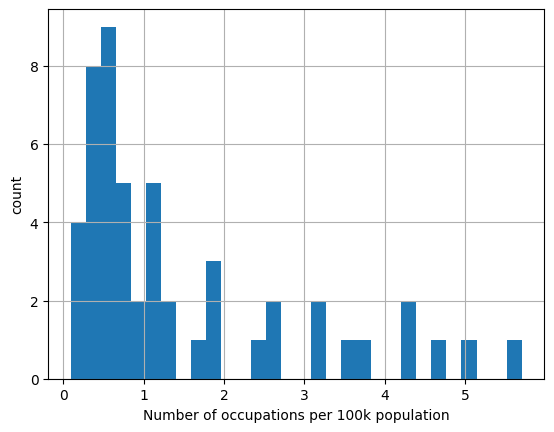

In [40]:
geo_sum_newind.occupation_per_100kcapita.hist(bins=30)
plt.xlabel('Number of occupations per 100k population')
plt.ylabel('count');

In [41]:
geo_sum_newind['occupation_per_100kcapita'].sort_values( ascending = False).head()

state
Wyoming                 5.701855
Vermont                 5.128296
North Dakota            4.592802
District of Columbia    4.392496
Alaska                  4.374304
Name: occupation_per_100kcapita, dtype: float64

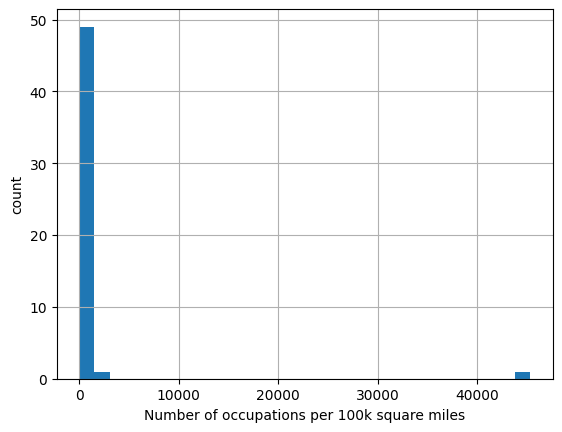

In [42]:
geo_sum_newind.occupation_per_100ksq_mile.hist(bins=30)
plt.xlabel('Number of occupations per 100k square miles')
plt.ylabel('count');

<div class="alert alert-info">We notice that they both have long tails, <br>
    We confirm that population and state size does not equate to more occupations.<br>
    Let's fix the small state area problem
</div>

In [43]:
geo_sum_newind['occupation_per_100ksq_mile'].sort_values( ascending = False).head()

state
District of Columbia    45361.428153
Rhode Island             2200.647249
Delaware                 1406.187224
Connecticut               667.508569
New Jersey                424.165998
Name: occupation_per_100ksq_mile, dtype: float64

<div class="alert alert-info">DC is the biggest outlier.<br>
    We also have 4 more small states. <br>
        We will drop these states for this plot
    </div>

In [44]:
geo_sum_newind_no_dc = geo_sum_newind.drop(['District of Columbia','Rhode Island','Delaware','Connecticut','New Jersey'])

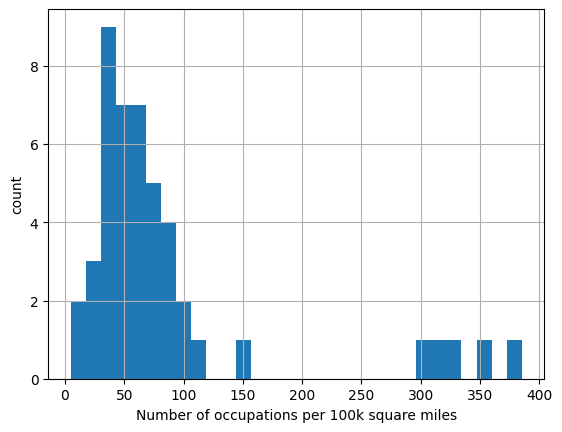

In [45]:
geo_sum_newind_no_dc.occupation_per_100ksq_mile.hist(bins=30)
plt.xlabel('Number of occupations per 100k square miles')
plt.ylabel('count');

<div class="alert alert-info">Much better to see the distribution. <br>
    This does not change the conclusion that <br>
    bigger state or higher population is not equla to more occupation
    </div>

<div class="alert alert-info">Occupation data does not have population and area.<br>
    Adding them to the df.
    </div>

In [46]:
occupation_data.head()


,occupation,state,hispanic,white,black,asian,pacific,indigenous,other,less_than_30,...,less_than_30_%,30_to_39_%,40_to_49_%,50_to_59_%,60+_%,male_%,female_%,missing-suppressed_raceethnicity_data_comment,missing-suppressed_age_data_comment,missing-suppressed_gender_data_comment
0,Advanced Practice Registered Nurses (excl. Cli...,Alabama,0.0,3989.0,418.0,81.0,0.0,0.0,0.0,529.0,...,11.637,34.294,24.747,21.755,7.567,18.918,81.082,Hispanic: Supressed; Native Hawaiian/ Pacific ...,NaN,NaN
1,Advanced Practice Registered Nurses (excl. Cli...,Alaska,0.0,643.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,44.706,30.065,NaN,17.124,NaN,98.954,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Less than 30 Years Old: Supressed; 50 to 59 Ye...,Male: Supressed
2,Advanced Practice Registered Nurses (excl. Cli...,Arizona,478.0,2998.0,125.0,193.0,0.0,0.0,122.0,95.0,...,2.404,29.833,24.595,24.949,18.219,19.104,80.896,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN
3,Advanced Practice Registered Nurses (excl. Cli...,Arkansas,0.0,1655.0,146.0,0.0,0.0,0.0,0.0,75.0,...,4.056,33.045,25.690,24.013,13.196,18.983,81.017,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,NaN,NaN
4,Advanced Practice Registered Nurses (excl. Cli...,California,1364.0,7661.0,826.0,3169.0,0.0,0.0,469.0,906.0,...,6.683,30.619,22.077,21.553,19.068,15.136,84.864,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN


In [47]:
geo_sum_newind.head()

,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female,population,area,occupation_per_100kcapita,occupation_per_100ksq_mile
state,,,,,,,,,,,,,,
Alabama,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0,0.734217,68.676078
Alaska,32,2511.0,825.0,190.0,24619.0,2115.0,1771.0,788.0,8795.0,26254.0,731545,665384.0,4.374304,4.809253
Arizona,37,9258.0,19154.0,200.0,170919.0,17458.0,68355.0,5776.0,72654.0,220344.0,7278717,113990.0,0.508331,32.458988
Arkansas,36,375.0,22797.0,0.0,100165.0,1738.0,3410.0,2245.0,24368.0,108725.0,3017804,53179.0,1.192920,67.695895
California,37,4152.0,136257.0,9411.0,631315.0,418165.0,489931.0,52819.0,440693.0,1302908.0,39512223,163695.0,0.093642,22.603012


In [48]:
# Reset index
geo_sum_newind_reset = geo_sum_newind.reset_index()

#adding population and area to occupation_data
# Ensure the 'state' column exists in both DataFrames and is of the same data type
if 'state' not in occupation_data.columns or 'state' not in geo_sum_newind_reset.columns:
    print("Error: 'state' column not found in one or both of the DataFrames.")
else:
    # Convert 'state' columns to string type for consistent merging
    occupation_data['state'] = occupation_data['state'].astype(str)
    geo_sum_newind_reset['state'] = geo_sum_newind_reset['state'].astype(str)


    #Force a reset of the index, regardless of its current state:
    occupation_data = occupation_data.reset_index(drop=True)  # drop=True discards old index
    geo_sum_newind_reset = geo_sum_newind_reset.reset_index(drop=True)  # drop=True discards old index
        
    # Merge the DataFrames using the 'state' column as the key
    occupation_data_new = pd.merge(occupation_data, geo_sum_newind_reset[['state', 'population', 'area','occupation_per_100kcapita','occupation_per_100ksq_mile']], on='state', how='left')

    # Handle missing data (NaN values) if necessary
    occupation_data_new['population'].fillna(0)
    occupation_data_new['area'].fillna(0)

    # Example: dropping rows with NaNs (could we risk removing a lot of data)
    # geo_sum_newind_reset.dropna(subset=['population', 'area'], inplace=True)

In [49]:
occupation_data_new.head()

,occupation,state,hispanic,white,black,asian,pacific,indigenous,other,less_than_30,...,60+_%,male_%,female_%,missing-suppressed_raceethnicity_data_comment,missing-suppressed_age_data_comment,missing-suppressed_gender_data_comment,population,area,occupation_per_100kcapita,occupation_per_100ksq_mile
0,Advanced Practice Registered Nurses (excl. Cli...,Alabama,0.0,3989.0,418.0,81.0,0.0,0.0,0.0,529.0,...,7.567,18.918,81.082,Hispanic: Supressed; Native Hawaiian/ Pacific ...,NaN,NaN,4903185,52420.0,0.734217,68.676078
1,Advanced Practice Registered Nurses (excl. Cli...,Alaska,0.0,643.0,0.0,0.0,0.0,0.0,0.0,NaN,...,17.124,NaN,98.954,Hispanic: [No Data]; Black (Non-Hispanic): [No...,Less than 30 Years Old: Supressed; 50 to 59 Ye...,Male: Supressed,731545,665384.0,4.374304,4.809253
2,Advanced Practice Registered Nurses (excl. Cli...,Arizona,478.0,2998.0,125.0,193.0,0.0,0.0,122.0,95.0,...,18.219,19.104,80.896,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,7278717,113990.0,0.508331,32.458988
3,Advanced Practice Registered Nurses (excl. Cli...,Arkansas,0.0,1655.0,146.0,0.0,0.0,0.0,0.0,75.0,...,13.196,18.983,81.017,Hispanic: Supressed; Asian (Non-Hispanic): Sup...,NaN,NaN,3017804,53179.0,1.192920,67.695895
4,Advanced Practice Registered Nurses (excl. Cli...,California,1364.0,7661.0,826.0,3169.0,0.0,0.0,469.0,906.0,...,19.068,15.136,84.864,Native Hawaiian/ Pacific Islander: Supressed; ...,NaN,NaN,39512223,163695.0,0.093642,22.603012


<div class="alert alert-info">Based on the data seen so far, it might be time to introduce additional publicly available dataset .<br>
</div>

In [50]:
health_services = pd.read_csv('../data/Hospital_Service_Area_2023.csv')
health_services.head()

,MEDICARE_PROV_NUM,ZIP_CD_OF_RESIDENCE,TOTAL_DAYS_OF_CARE,TOTAL_CHARGES,TOTAL_CASES
0,01S007,28712,*,*,*
1,01S007,32435,*,*,*
2,01S007,32536,*,*,*
3,01S007,32547,*,*,*
4,01S007,36009,*,*,*


In [51]:
health_services['TOTAL_DAYS_OF_CARE'].unique()

array(['*         ', '0000000239', '0000000168', ..., '0000002893',
       '0000003361', nan], shape=(5525,), dtype=object)

In [52]:
health_fam_practice = pd.read_csv('../data/Family_Practice.csv')
health_fam_practice.head()

,zip_code,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient
0,210,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
1,211,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
2,212,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
3,213,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
4,214,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214


<div class="alert alert-info">health_services and health_fam_practice could be useful.<br>
</div>

<div class="alert alert-info">Some of the new data contains zip without city or state name.<br>
We will read a mapping csv file. <br>
The two datasets we will use for this are:<br>
health_services and health_fam_practice
</div>

In [53]:
# Load ZIP code to city/state mapping data
zip_data = pd.read_csv("../data/uszips.csv") 

zip_data.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,16721.0,100.2,72001,Adjuntas,"{""72001"": 98.74, ""72141"": 1.26}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37510.0,477.6,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,48317.0,543.1,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,606,18.16585,-66.93716,Maricao,PR,Puerto Rico,True,NaN,5435.0,47.3,72093,Maricao,"{""72093"": 82.27, ""72153"": 11.66, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29110,-67.12243,Anasco,PR,Puerto Rico,True,NaN,25413.0,264.4,72011,Añasco,"{""72011"": 96.71, ""72099"": 2.82, ""72083"": 0.37,...",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003,False,False,America/Puerto_Rico


In [54]:
#Only do this if memory becomes an issue. 
#zip_data = reduce_memory_usage(zip_data)

In [55]:
#Check for NaN in zip in health_services
# Ensure both datasets have a 'ZIP' column (adjust column names if needed)
zip_data.rename(columns={'state_name': 'state'}, inplace=True)
health_services.rename(columns={'ZIP_CD_OF_RESIDENCE': 'zip'}, inplace=True)
health_fam_practice.rename(columns={'zip_code': 'zip'}, inplace=True)
#converting all column names to lower case
for df in [zip_data, health_services, health_fam_practice]:
    df.columns = df.columns.str.lower()

has_nan = health_services['zip'].isnull().any()

if has_nan:
    print("There are NaN values in the 'zip' column.")
else:
    print("There are no NaN values in the 'zip' column.")

There are NaN values in the 'zip' column.


In [56]:
#Check how many rows are impacted
rows_with_nan = health_services[health_services['zip'].isnull()].index
rows_with_nan

Index([1139665], dtype='int64')

In [57]:
health_services = health_services.drop(rows_with_nan)

In [58]:
health_services.columns

Index(['medicare_prov_num', 'zip', 'total_days_of_care', 'total_charges',
       'total_cases'],
      dtype='object')

In [59]:
health_services['total_days_of_care'].isna()

0          False
1          False
2          False
3          False
4          False
           ...  
1139660    False
1139661    False
1139662    False
1139663    False
1139664    False
Name: total_days_of_care, Length: 1139665, dtype: bool

In [60]:
health_services.dtypes

medicare_prov_num     object
zip                   object
total_days_of_care    object
total_charges         object
total_cases           object
dtype: object

In [61]:
# Checking how many rows have * for these columns as seen from the head print above. 
cols_to_check = ['total_days_of_care', 'total_charges', 'total_cases']

health_services['total_days_of_care'] = health_services['total_days_of_care'].str.strip()
health_services['total_charges'] = health_services['total_charges'].str.strip()
health_services['total_cases'] = health_services['total_cases'].str.strip()

# Create boolean masks
mask_days = health_services['total_days_of_care'] == '*'
mask_charges = health_services['total_charges'] == '*'
mask_cases = health_services['total_cases'] == '*'

# Combine the masks
combined_mask = mask_days & mask_charges & mask_cases

# Count the rows
count = combined_mask.sum()

print(f"Number of rows with '*' in all three columns: {count}")

Number of rows with '*' in all three columns: 996700


In [62]:
print(f"{(count/len(health_services) * 100):.2f}%")

87.46%


<div class="alert alert-info">87% of the main data is missing.<br>
Let's impute using multiple imputation using IterativeImputer. <br>
    The limitation is that we are reaching too much to impute data from just 13% of known values.<br>
    The other option we have is to drop 87% of th edata. 
    </div>

<div class="alert alert-info"> Check to see if the providers do not have a representation in particular zip codes<br>
if that is the case we drop the rows<br>
No further sampling will be required if that is the case.</div>

In [63]:
cols_to_check = ['total_days_of_care', 'total_charges', 'total_cases']

# Create results_df (rows with NO asterisks in the specified columns)
results_df = health_services[
    (health_services[cols_to_check] != '*').all(axis=1)
]

# Create asterisk_df (rows with ONLY asterisks in the specified columns)
asterisk_df = health_services[
    (health_services[cols_to_check] == '*').all(axis=1)
]

# Print the DataFrames
print("Results DataFrame (no asterisks):")
print(results_df.head())

print("\nAsterisk DataFrame (only asterisks):")
print(asterisk_df.head())

health_services = results_df
health_services.shape

Results DataFrame (no asterisks):
    medicare_prov_num    zip total_days_of_care total_charges total_cases
27             01S007  36467         0000000239    0000331859   000000017
106            01S011  35215         0000000168    0000518435   000000011
179            01S012  35768         0000000267    0001026402   000000014
199            01S012  35967         0000000260    0001295848   000000018
230            01S016  35040         0000000292    0001424855   000000014

Asterisk DataFrame (only asterisks):
  medicare_prov_num    zip total_days_of_care total_charges total_cases
0            01S007  28712                  *             *           *
1            01S007  32435                  *             *           *
2            01S007  32536                  *             *           *
3            01S007  32547                  *             *           *
4            01S007  36009                  *             *           *


(142965, 5)

<div class="alert alert-info">It is clear we don't need the row with *<br>
They have no significance and will create unnecessary bias when modeling.</div>

In [64]:
del results_df

In [65]:
del asterisk_df

In [66]:
health_services.dtypes

medicare_prov_num     object
zip                   object
total_days_of_care    object
total_charges         object
total_cases           object
dtype: object

In [67]:
#Check for NaN in zip in health_fam_practice
#health_fam_practice.info()
health_fam_practice.rename(columns={'zip_code':'zip'},inplace=True)
has_nanfp = health_fam_practice['zip'].isnull().any()

if has_nanfp:
    print("There are NaN values in the 'zip' column.")
else:
    print("There are no NaN values in the 'zip' column.")

There are no NaN values in the 'zip' column.


In [68]:
del has_nanfp

<div class="alert alert-info">Time to add city and state aligned with zip from zip_data.<br>
This change on both health_services and health_fam_practice

</div>

In [69]:
health_services['zip'] = (
    health_services['zip'].astype(str).str.strip().str.zfill(5)
)
zip_data['zip'] = (
    zip_data['zip'].astype(str).str.strip().str.zfill(5)
)
health_fam_practice['zip'] = (
    health_fam_practice['zip'].astype(str).str.strip().str.zfill(5)
)



In [70]:
health_services.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases
27,01S007,36467,0000000239,0000331859,000000017
106,01S011,35215,0000000168,0000518435,000000011
179,01S012,35768,0000000267,0001026402,000000014
199,01S012,35967,0000000260,0001295848,000000018
230,01S016,35040,0000000292,0001424855,000000014


In [71]:
health_services = merge_with_zip_data(health_services,zip_data)

In [72]:
health_services.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases,city,state
0,01S007,36467,0000000239,0000331859,000000017,Opp,Alabama
1,01S011,35215,0000000168,0000518435,000000011,Birmingham,Alabama
2,01S012,35768,0000000267,0001026402,000000014,Scottsboro,Alabama
3,01S012,35967,0000000260,0001295848,000000018,Fort Payne,Alabama
4,01S016,35040,0000000292,0001424855,000000014,Calera,Alabama


<div class="alert alert-info"> health_fam_practice does not have missing or * data.</div>

In [73]:
health_fam_practice.head()

,zip,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient
0,00210,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
1,00211,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
2,00212,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
3,00213,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214
4,00214,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214


In [74]:
health_fam_practice = merge_with_zip_data(health_fam_practice,zip_data)


In [75]:
health_fam_practice.head()

,zip,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient,city,state
0,00210,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214,NaN,NaN
1,00211,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214,NaN,NaN
2,00212,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214,NaN,NaN
3,00213,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214,NaN,NaN
4,00214,57.752,174.264,89.144,14.438,43.566,22.286,99203,18.704,142.152,101.544,4.676,35.538,25.386,99214,NaN,NaN


In [76]:
health_services.dtypes

medicare_prov_num     object
zip                   object
total_days_of_care    object
total_charges         object
total_cases           object
city                  object
state                 object
dtype: object

In [77]:
health_fam_practice.shape

(42966, 17)

In [78]:
# Convert zip to string to ensure .str methods work
health_services['zip'] = health_services['zip'].astype(str)
zip_data['zip'] = zip_data['zip'].astype(str)
health_services.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases,city,state
0,01S007,36467,0000000239,0000331859,000000017,Opp,Alabama
1,01S011,35215,0000000168,0000518435,000000011,Birmingham,Alabama
2,01S012,35768,0000000267,0001026402,000000014,Scottsboro,Alabama
3,01S012,35967,0000000260,0001295848,000000018,Fort Payne,Alabama
4,01S016,35040,0000000292,0001424855,000000014,Calera,Alabama


In [79]:
rows_with_nan2 = health_services[health_services['city'].isna() & health_services['state'].isna()]
rows_with_nan2['zip'].unique

<bound method Series.unique of 31        35502
38        35403
172       32447
184       36072
188       36302
          ...  
141869    79913
141896    68501
141920    77305
141956    77383
142650    77805
Name: zip, Length: 3894, dtype: object>

In [80]:
# Find rows in health_services where 'city' and 'state' are NaN
missing_city_state = health_services[health_services['city'].isna() & health_services['state'].isna()]

# Check if those zip codes exist in health_services
missing_zip_codes = missing_city_state['zip'].unique()

# Check if these zip codes exist in zip_data
missing_in_zip_data = zip_data[zip_data['zip'].isin(missing_zip_codes)]

print(f"Number of zip codes in health_services with missing city/state: {len(missing_zip_codes)}")
print(f"Number of matching zip codes in zip_data: {missing_in_zip_data.shape[0]}")

Number of zip codes in health_services with missing city/state: 2178
Number of matching zip codes in zip_data: 0


In [81]:
# Check for empty strings or None values in the 'state' column
rows_with_empty_state = health_services[health_services['state'].apply(lambda x: x == '' or x is None)]

# Check the unique values in the 'state' column that are not NaN
print(health_services['state'].unique())

['Alabama' nan 'Florida' 'Georgia' 'Tennessee' 'Mississippi' 'Alaska'
 'Arizona' 'New Mexico' 'South Dakota' 'California' 'Nevada' 'Arkansas'
 'Oklahoma' 'Texas' 'Missouri' 'Oregon' 'New Jersey' 'Utah' 'Colorado'
 'Wyoming' 'Nebraska' 'Kansas' 'Hawaii' 'Connecticut' 'Massachusetts'
 'New York' 'Rhode Island' 'Vermont' 'Delaware' 'Maryland' 'Pennsylvania'
 'District of Columbia' 'Virginia' 'Virgin Islands' 'North Carolina'
 'South Carolina' 'Puerto Rico' 'Kentucky' 'American Samoa' 'Idaho'
 'Washington' 'Montana' 'Illinois' 'Iowa' 'Wisconsin' 'Indiana' 'Michigan'
 'Ohio' 'Minnesota' 'West Virginia' 'Louisiana' 'Maine' 'New Hampshire'
 'North Dakota' 'Guam' 'Northern Mariana Islands']


In [82]:
# Check rows where both city and state are "falsy" (empty string, None, NaN)
rows_with_falsy_values = health_services[health_services['city'].apply(lambda x: pd.isna(x) or x == '') &
                                         health_services['state'].apply(lambda x: pd.isna(x) or x == '')]

print(f"Rows with both city and state as falsy values: {rows_with_falsy_values.shape[0]}")

Rows with both city and state as falsy values: 3894


In [83]:
# Check for missing or invalid zip codes in health_services
invalid_zips = health_services[health_services['zip'].isna() | (health_services['zip'].str.len() != 5)]
print(f"Invalid or missing zip codes in health_services: {invalid_zips.shape[0]}")

Invalid or missing zip codes in health_services: 0


In [84]:
# Find rows in health_services that did not get matched with zip_data
unmatched_zips = health_services[health_services['zip'].isin(zip_data['zip']) == False]
print(f"Unmatched zip codes in health_services: {unmatched_zips.shape[0]}")

Unmatched zip codes in health_services: 3894


In [85]:
health_services.shape

(142965, 7)

In [86]:
# Drop rows with invalid or missing zip codes
health_services.dropna(subset=['zip'], inplace=True)
health_services = health_services[health_services['zip'].str.len() == 5]

<div class="alert alert-info"><strong>Since imputing * in health_services is no longer needed</strong><br>
    We no longer have a need to sample the data, at this point.
</div>

In [87]:
#health_services = health_services.sample(frac=0.20, random_state=42).reset_index(drop=True)

<div class="alert alert-info"><strong>Let's remove territories from health_services and health_fam_practice</strong></div>

In [88]:
# List of 50 states + District of Columbia
valid_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 
    'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
    'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia'
]

# Filter health_services to only include rows where state is in the valid states list
health_services = health_services[health_services['state'].isin(valid_states)]

# Check the resulting row count and a preview
print(f"Filtered rows count: {health_services.shape[0]}\n")
print(health_services[['zip', 'city', 'state']].head())  # Preview

Filtered rows count: 138030

     zip        city    state
0  36467         Opp  Alabama
1  35215  Birmingham  Alabama
2  35768  Scottsboro  Alabama
3  35967  Fort Payne  Alabama
4  35040      Calera  Alabama


<div class="alert alert-info"><strong>There are zip codes in health_services not found zip_data</strong><br>
    Assumption is to find a zip code that is either one number higher or one number lower (i.e., plus or minus 1) <br>from the missing zip and use the city and state of the found zip code.<br>
<br><strong>Approach:<br></strong>
Identify the Missing Zips: <br>
    First, identify the rows in health_services where the zip codes are missing or don't have a match in zip_data.<br><br>
Find Closest Zip Code: <br>
    For each missing zip, search zip_data for the zip code that is either one greater or one less than the missing zip code.<br><br>
Assign the Corresponding City/State: Use the city and state from the found zip code to fill the missing city/state.</strong></div>

In [89]:
counths = health_services['city'].isna().sum()
counths

np.int64(0)

In [90]:
counthf = health_fam_practice['city'].isna().sum()
counthf

np.int64(9183)

<div class="alert alert-info"><strong>We have a clean dataset</strong><br>

<br>
read csv from onedrive or Google drive
</div>

In [91]:
health_services.shape

(138030, 7)

In [92]:
health_fam_practice.shape

(42966, 17)

In [93]:
health_services = fill_missing_city_state(health_services)

No missing city/state values to fill.


In [94]:
health_fam_practice = fill_missing_city_state(health_fam_practice)

Filled missing city/state values for 7473 ZIP codes.


In [95]:
health_services.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases,city,state
0,01S007,36467,0000000239,0000331859,000000017,Opp,Alabama
1,01S011,35215,0000000168,0000518435,000000011,Birmingham,Alabama
2,01S012,35768,0000000267,0001026402,000000014,Scottsboro,Alabama
3,01S012,35967,0000000260,0001295848,000000018,Fort Payne,Alabama
4,01S016,35040,0000000292,0001424855,000000014,Calera,Alabama


In [96]:
# Check the remaining rows with missing city and state values
#remaining_missing = health_services[health_services['city'].isna() & health_services['state'].isna()]
#print(f"Remaining rows with missing city and state: {remaining_missing.shape[0]}")
#remaining_missing.head()  # Preview some rows with missing city/state

In [97]:
# Get the zip codes that are still missing city and state
#missing_zip_codes = remaining_missing['zip'].unique()
#print(f"Missing zip codes: {missing_zip_codes}")

In [98]:
del zip_data

In [99]:
# Filter health_fam_practice to only include rows where state is in the valid states list
health_fam_practice = health_fam_practice[health_fam_practice['state'].isin(valid_states)]

# Check the resulting row count and a preview
print(f"Filtered rows count: {health_fam_practice.shape[0]}\n")
print(health_fam_practice[['zip', 'city', 'state']].head())  # Preview

Filtered rows count: 33635

       zip         city          state
200  01001       Agawam  Massachusetts
201  01002      Amherst  Massachusetts
202  01003      Amherst  Massachusetts
210  01005        Barre  Massachusetts
211  01007  Belchertown  Massachusetts


In [100]:
health_fam_practice.head()

,zip,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient,city,state
200,01001,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Agawam,Massachusetts
201,01002,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Amherst,Massachusetts
202,01003,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Amherst,Massachusetts
210,01005,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Barre,Massachusetts
211,01007,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Belchertown,Massachusetts


In [101]:
# Check the remaining rows with missing city and state values
remaining_missing2 = health_fam_practice[health_fam_practice['city'].isna() & health_fam_practice['state'].isna()]
print(f"Remaining rows with missing city and state: {remaining_missing2.shape[0]}")
remaining_missing2.head()  # Preview some rows with missing city/state

Remaining rows with missing city and state: 0


,zip,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient,city,state


In [102]:
health_fam_practice.shape

(33635, 17)

<div class="alert alert-info"><strong>Compbining health_services with occupation_data<br>
    And health_fam_practice with occupation_data</strong></div>

In [103]:
# Convert occupation_data['state'] to lowercase *before* calling the merge function
occupation_data['state'] = occupation_data['state'].str.strip().str.lower()

In [104]:
# Convert health_services['state'] to lowercase *before* calling the merge function
health_services['state'] = health_services['state'].str.strip().str.lower()

In [105]:
# Convert health_fam_practice['state'] to lowercase *before* calling the merge function
health_fam_practice.loc[:, 'state'] = health_fam_practice['state'].str.strip().str.lower()

In [106]:
health_services.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases,city,state
0,01S007,36467,0000000239,0000331859,000000017,Opp,alabama
1,01S011,35215,0000000168,0000518435,000000011,Birmingham,alabama
2,01S012,35768,0000000267,0001026402,000000014,Scottsboro,alabama
3,01S012,35967,0000000260,0001295848,000000018,Fort Payne,alabama
4,01S016,35040,0000000292,0001424855,000000014,Calera,alabama


In [107]:
health_fam_practice.head()

,zip,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient,city,state
200,01001,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Agawam,massachusetts
201,01002,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Amherst,massachusetts
202,01003,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Amherst,massachusetts
210,01005,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Barre,massachusetts
211,01007,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Belchertown,massachusetts


In [108]:
health_services_with_occupation = merge_with_occupation_data(health_services)


In [109]:
health_services_with_occupation.shape

(5067356, 33)

In [110]:
health_services_with_occupation.head()

,total_days_of_care,total_charges,total_cases,state,occupation,hispanic,white,black,asian,pacific,...,pacific_%,indigenous_%,other_%,less_than_30_%,30_to_39_%,40_to_49_%,50_to_59_%,60+_%,male_%,female_%
0,0000000239,0000331859,000000017,alabama,Advanced Practice Registered Nurses (excl. Cli...,0.0,3989.0,418.0,81.0,0.0,...,0.0,0.0,0.0,11.637,34.294,24.747,21.755,7.567,18.918,81.082
1,0000000239,0000331859,000000017,alabama,Chiropractors,0.0,572.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,19.625,31.741,37.543,11.092,69.966,30.034
2,0000000239,0000331859,000000017,alabama,Counselors,110.0,2572.0,1647.0,0.0,0.0,...,0.0,0.0,0.0,18.319,30.599,17.977,19.526,13.579,22.192,77.808
3,0000000239,0000331859,000000017,alabama,Dental Assistants,0.0,2865.0,268.0,0.0,0.0,...,0.0,0.0,0.0,41.868,23.602,17.789,12.421,4.320,2.764,97.236
4,0000000239,0000331859,000000017,alabama,Dental Hygienists,0.0,3514.0,204.0,0.0,0.0,...,0.0,0.0,0.0,8.079,19.073,33.510,26.728,12.609,0.000,98.490


<div class="alert alert-info"><strong>We have a large df</strong><br>
    We need to sample the data at about 10%.
</div>

In [111]:
health_services_with_occupation = health_services_with_occupation.sample(frac=0.10, random_state=42).reset_index(drop=True)

In [112]:
health_services_with_occupation.shape

(506736, 33)

In [113]:
occupation_data.shape

(1832, 33)

In [114]:
#Repeating the above process for health_fam_practice
health_fam_prac_with_occupation = merge_with_occupation_data(health_fam_practice)

if health_fam_prac_with_occupation is not None:
    # Process the merged DataFrame further if needed
    health_fam_prac_with_occupation.head()
else:
    print("Merge failed.")

In [115]:
health_fam_prac_with_occupation.shape

(1226732, 44)

<div class="alert alert-info"><strong>Again we produced a large df</strong><br>
    We need to sample the data at about 10%.
</div>

In [116]:
health_fam_prac_with_occupation = health_fam_prac_with_occupation.sample(frac=0.10, random_state=42).reset_index(drop=True)

In [117]:
health_fam_prac_with_occupation.shape

(122673, 44)

<div class="alert alert-info"><strong>Visualize the data
</div>

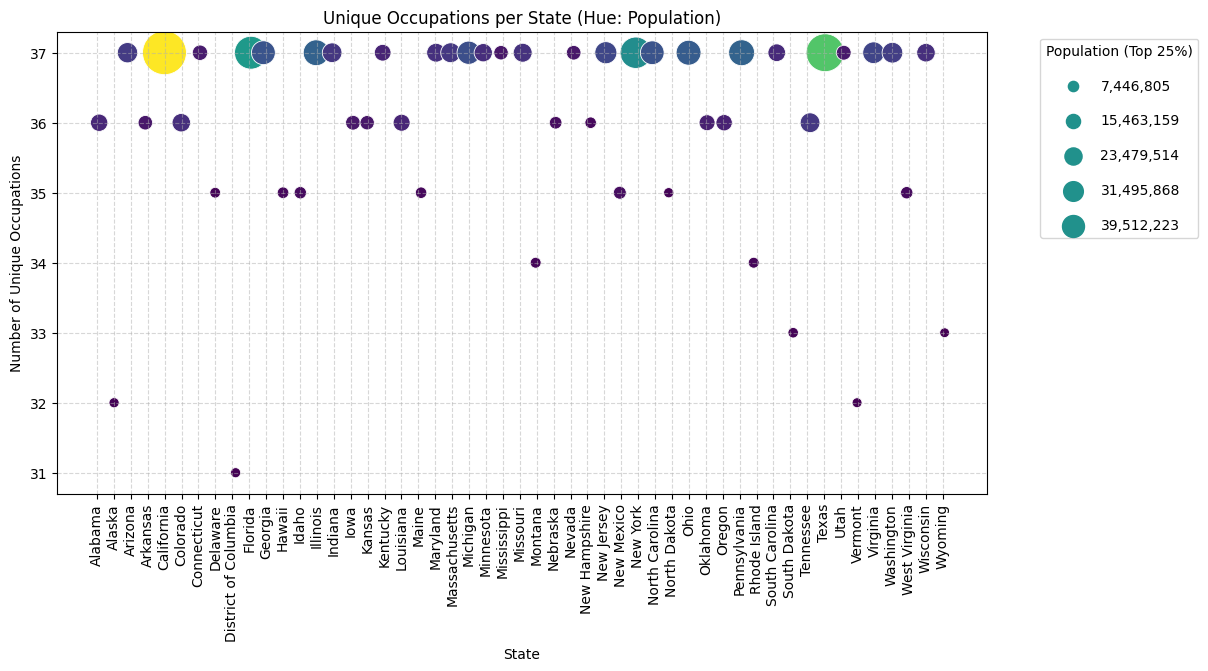

In [118]:
# Visualization
plot_occupation_distribution(occupation_data_new)

In [119]:
# Reset index only once
geo_sum_newind_reset = geo_sum_newind.reset_index()

# Standardize state column in both DataFrames
occupation_data_new['state'] = occupation_data_new['state'].astype(str).str.strip().str.upper()
geo_sum_newind_reset['state'] = geo_sum_newind_reset['state'].astype(str).str.strip().str.upper()

# Merge without resetting again
occupation_data_pop_area = geo_sum_newind_reset.merge(
    occupation_data_new[['state', 'occupation']], 
    on='state', 
    how='left'
)

occupation_data_pop_area.head()


,state,occupation_per_state,state_total_indigenous,state_total_black,state_total_pacific,state_total_white,state_total_asian,state_total_hispanic,state_total_other,state_total_male,state_total_female,population,area,occupation_per_100kcapita,occupation_per_100ksq_mile,occupation
0,ALABAMA,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0,0.734217,68.676078,Advanced Practice Registered Nurses (excl. Cli...
1,ALABAMA,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0,0.734217,68.676078,Chiropractors
2,ALABAMA,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0,0.734217,68.676078,Counselors
3,ALABAMA,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0,0.734217,68.676078,Dental Assistants
4,ALABAMA,36,168.0,55123.0,0.0,137591.0,2784.0,2726.0,2346.0,37143.0,166539.0,4903185,52420.0,0.734217,68.676078,Dental Hygienists


<div class="alert alert-info"><strong>Adding population and area to occupation_data<br>
    We will then plot
</div>

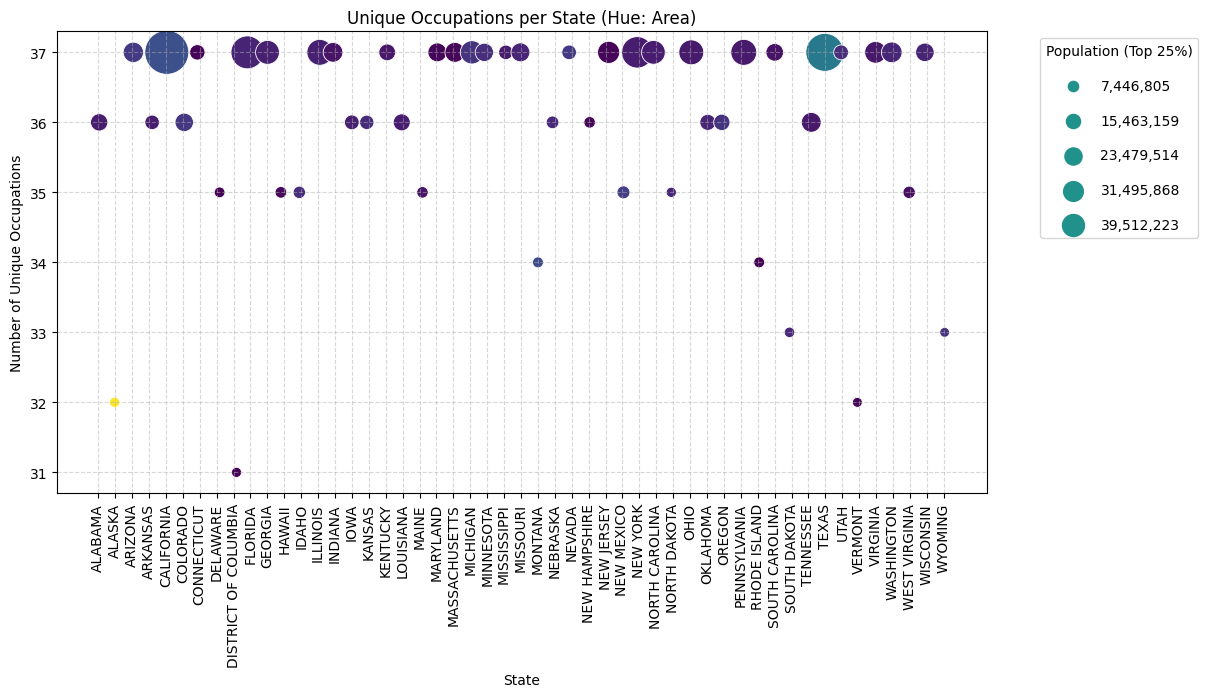

In [120]:
#geo_sum_newind = geo_sum_newind.reset_index(drop=True)
# Remove duplicate columns (if 'state' appears twice)
geo_sum_newind_reset = geo_sum_newind_reset.loc[:, ~geo_sum_newind_reset.columns.duplicated()]
# Convert the population column to numeric and drop rows with missing population
geo_sum_newind_reset['population'] = pd.to_numeric(geo_sum_newind_reset['population'], errors='coerce')
geo_sum_newind_reset = geo_sum_newind_reset.dropna(subset=['population'])
geo_sum_newind['area'] = pd.to_numeric(geo_sum_newind_reset['area'], errors='coerce')


plot_occupation_distribution(occupation_data_new,'area')

<div class="alert alert-info"><strong>Occupation has a tight range between the 50 US state plus DC</strong><br>
The plot with hue by Population or by Area appear to be similar. </div>

In [121]:
del occupation_data

In [122]:
del geo_sum_newind

<div class="alert alert-info"><strong>Time to merge health_services and health_fam_practice </strong></div>

In [123]:
health_services.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases,city,state
0,01S007,36467,0000000239,0000331859,000000017,Opp,alabama
1,01S011,35215,0000000168,0000518435,000000011,Birmingham,alabama
2,01S012,35768,0000000267,0001026402,000000014,Scottsboro,alabama
3,01S012,35967,0000000260,0001295848,000000018,Fort Payne,alabama
4,01S016,35040,0000000292,0001424855,000000014,Calera,alabama


In [124]:
health_fam_practice.head()

,zip,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient,city,state
200,01001,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Agawam,massachusetts
201,01002,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Amherst,massachusetts
202,01003,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Amherst,massachusetts
210,01005,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Barre,massachusetts
211,01007,58.864,177.368,90.704,14.716,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214,Belchertown,massachusetts


In [125]:
health_services.columns

Index(['medicare_prov_num', 'zip', 'total_days_of_care', 'total_charges',
       'total_cases', 'city', 'state'],
      dtype='object')

In [126]:
health_fam_practice.shape

(33635, 17)

In [127]:
print(health_services['zip'].head())
print(health_fam_practice['zip'].head())
print(health_services['zip'].isnull().sum())
print(health_fam_practice['zip'].isnull().sum())

0    36467
1    35215
2    35768
3    35967
4    35040
Name: zip, dtype: object
200    01001
201    01002
202    01003
210    01005
211    01007
Name: zip, dtype: object
0
0


In [128]:
common_columns = ['zip', 'city', 'state']
health_serv_pract = merge_dataframes(health_services, health_fam_practice, common_columns)
health_serv_pract.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases,city,state,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,...,max_copay_for_new_patient,mode_copay_for_new_patient,most_utilized_procedure_code_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,most_utilized_procedure_code_for_established_patient
0,070002,01001,0000000095,0001430257,000000013,Agawam,massachusetts,58.864,177.368,90.704,...,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214
1,22T066,01001,0000000191,0000608763,000000017,Agawam,massachusetts,58.864,177.368,90.704,...,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214
2,220024,01001,0000000185,0000687951,000000026,Agawam,massachusetts,58.864,177.368,90.704,...,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214
3,220062,01001,0000000076,0000130588,000000012,Agawam,massachusetts,58.864,177.368,90.704,...,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214
4,220065,01001,0000000363,0001297629,000000092,Agawam,massachusetts,58.864,177.368,90.704,...,44.342,22.676,99203,19.112,144.84,103.48,4.778,36.21,25.87,99214


<div class="alert alert-info"><strong>Checking if there are columns with same value across all rows.</strong><br>
    If they exist, we drop them.
</div>

In [129]:
# Loop through all columns ending with '_patient' and check if they are constant
for col in [c for c in health_serv_pract.columns if c.endswith('_patient')]:
    unique_count = health_serv_pract[col].nunique()
    if unique_count == 1:
        print(f"{col} is constant across all rows: {health_serv_pract[col].iloc[0]}")
    else:
        print(f"{col} has {unique_count} unique values.")

min_medicare_pricing_for_new_patient has 92 unique values.
max_medicare_pricing_for_new_patient has 93 unique values.
mode_medicare_pricing_for_new_patient has 93 unique values.
min_copay_for_new_patient has 92 unique values.
max_copay_for_new_patient has 93 unique values.
mode_copay_for_new_patient has 93 unique values.
most_utilized_procedure_code_for_new_patient is constant across all rows: 99203
min_medicare_pricing_for_established_patient has 89 unique values.
max_medicare_pricing_for_established_patient has 97 unique values.
mode_medicare_pricing_for_established_patient has 96 unique values.
min_copay_for_established_patient has 89 unique values.
max_copay_for_established_patient has 97 unique values.
mode_copay_for_established_patient has 96 unique values.
most_utilized_procedure_code_for_established_patient is constant across all rows: 99214


In [130]:
#health_services_with_occupation = health_services_with_occupation.sample(frac=0.10, random_state=42).reset_index(drop=True)

In [131]:
columns_to_drop = [
    'most_utilized_procedure_code_for_new_patient',
    'most_utilized_procedure_code_for_established_patient'
    
]
health_serv_pract.drop(columns=columns_to_drop, inplace=True)
print("Dropped columns:", columns_to_drop)

Dropped columns: ['most_utilized_procedure_code_for_new_patient', 'most_utilized_procedure_code_for_established_patient']


In [132]:
# Grouping the full dataset by zip, then city, then state
# Convert columns to numeric before summing
health_serv_pract[['total_days_of_care', 'total_charges', 'total_cases']] = health_serv_pract[
    ['total_days_of_care', 'total_charges', 'total_cases']
].apply(pd.to_numeric, errors='coerce')

# Perform grouping and summation
grouped_df = health_serv_pract.groupby(['state', 'city', 'zip'])[
    ['total_days_of_care', 'total_charges', 'total_cases']
].sum().reset_index()

# Ensure final numeric type (int64)
grouped_df[['total_days_of_care', 'total_charges', 'total_cases']] = grouped_df[
    ['total_days_of_care', 'total_charges', 'total_cases']
].fillna(0).astype('int64')


In [133]:
grouped_df.head()

,state,city,zip,total_days_of_care,total_charges,total_cases
0,alabama,Abbeville,36310,2940,38899122,500
1,alabama,Adamsville,35005,1903,32141596,335
2,alabama,Addison,35540,431,4066443,114
3,alabama,Adger,35006,1261,17156748,209
4,alabama,Akron,35441,318,2117717,43


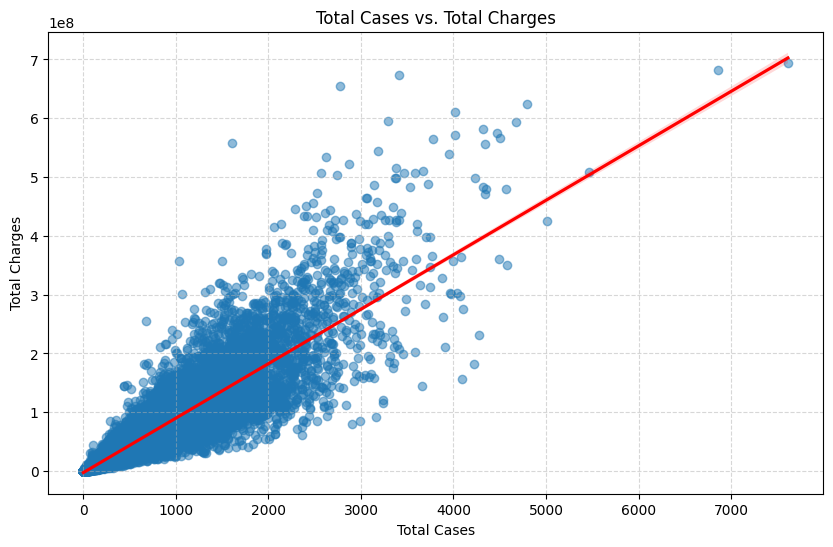

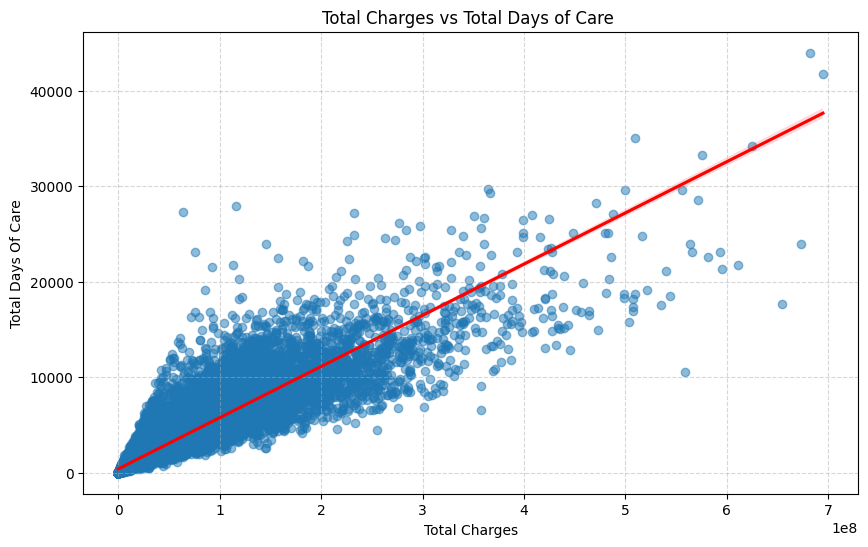

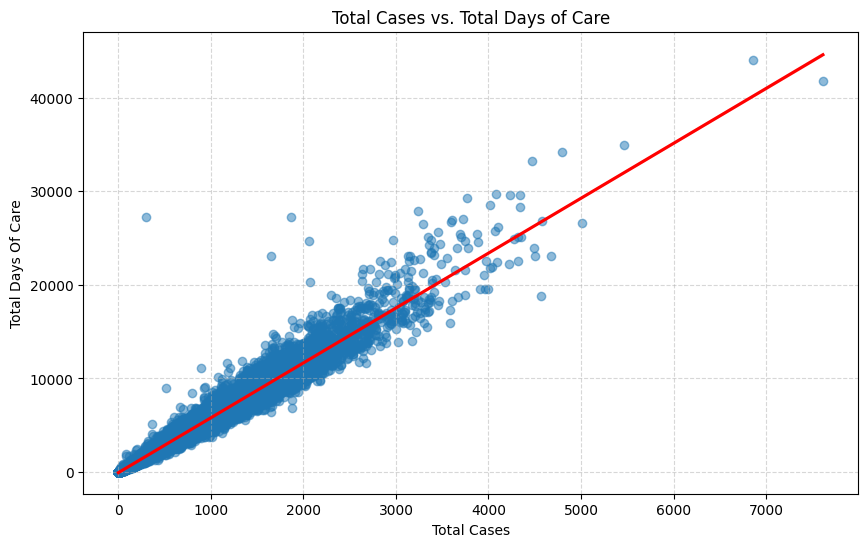

In [134]:
# Call the function for each pair of variables
plot_regression('total_cases', 'total_charges', grouped_df, "Total Cases vs. Total Charges")
plot_regression('total_charges','total_days_of_care', grouped_df, "Total Charges vs Total Days of Care ")
plot_regression('total_cases','total_days_of_care' , grouped_df, "Total Cases vs. Total Days of Care")

<div class="alert alert-info">The relationship between the three features is linear.<br>
    Some outliers exist. As total cases increase we see greater variance.<br>
    The varability is greater as days of care increases, the charges are no longer close to the regression line.
</div>

In [135]:
del grouped_df

<div class="alert alert-info"><h3>Classify locations<br></h3>
<strong>We will use the IRS income data to understand zip income levels</strong>
</div>

In [136]:
irs_household_income=pd.read_csv('../data/22zpallagi.csv')


In [137]:
irs_household_income.shape

(166131, 165)

In [138]:
irs_household_income.columns

Index(['STATEFIPS', 'STATE', 'zipcode', 'agi_stub', 'N1', 'mars1', 'MARS2',
       'MARS4', 'ELF', 'CPREP',
       ...
       'N85300', 'A85300', 'N11901', 'A11901', 'N11900', 'A11900', 'N11902',
       'A11902', 'N12000', 'A12000'],
      dtype='object', length=165)

In [139]:
# Ensure ZIP codes are treated as strings in both datasets
irs_household_income['zipcode'] = irs_household_income['zipcode'].astype(str).str.zfill(5)
health_serv_pract['zip'] = health_serv_pract['zip'].astype(str).str.zfill(5)

In [140]:
#Only do this if memory becomes an issue. 
#irs_household_income = reduce_memory_usage(irs_household_income)

In [141]:
irs_household_income.describe()

,STATEFIPS,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
count,166131.000000,166131.000000,1.661310e+05,1.661310e+05,1.661310e+05,166131.000000,1.661310e+05,166131.000000,1.661310e+05,1.661310e+05,...,1.661310e+05,1.661310e+05,1.661310e+05,1.661310e+05,1.661310e+05,1.661310e+05,1.661310e+05,1.661310e+05,166131.000000,1.661310e+05
mean,29.671374,3.499967,1.880469e+03,9.356044e+02,6.474709e+02,252.456014,1.757546e+03,64.420186,9.979981e+02,1.161680e+03,...,8.326730e+01,4.275619e+02,4.965237e+02,3.276094e+03,1.323436e+03,5.602519e+03,1.283797e+03,4.121674e+03,49.835311,1.405750e+03
std,15.115855,1.707866,3.568838e+04,2.079347e+04,1.237187e+04,5835.844422,3.317587e+04,1396.107563,1.954979e+04,2.301358e+04,...,4.139449e+03,2.439035e+04,9.416098e+03,1.325102e+05,2.599764e+04,1.266632e+05,2.558545e+04,7.817781e+04,1148.684775,6.601914e+04
min,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,18.000000,2.000000,8.000000e+01,3.000000e+01,4.000000e+01,0.000000,8.000000e+01,0.000000,5.000000e+01,4.000000e+01,...,0.000000e+00,0.000000e+00,3.000000e+01,4.000000e+01,5.000000e+01,1.770000e+02,5.000000e+01,1.580000e+02,0.000000,0.000000e+00
50%,29.000000,3.000000,2.800000e+02,1.000000e+02,1.100000e+02,30.000000,2.700000e+02,0.000000,1.600000e+02,1.600000e+02,...,0.000000e+00,0.000000e+00,7.000000e+01,2.090000e+02,1.900000e+02,6.830000e+02,1.800000e+02,6.010000e+02,0.000000,0.000000e+00
75%,42.000000,5.000000,1.160000e+03,4.600000e+02,3.600000e+02,110.000000,1.090000e+03,40.000000,6.100000e+02,6.700000e+02,...,0.000000e+00,0.000000e+00,3.000000e+02,9.060000e+02,7.800000e+02,2.706000e+03,7.400000e+02,2.381000e+03,30.000000,8.400000e+01
max,56.000000,6.000000,4.561120e+06,3.340290e+06,1.845920e+06,826690.000000,4.144060e+06,222430.000000,2.671110e+06,2.876130e+06,...,1.173210e+06,5.822695e+06,1.378580e+06,4.265502e+07,3.336930e+06,2.216380e+07,3.312050e+06,8.425143e+06,207870.000000,1.520072e+07


In [142]:
# Choose an appropriate income column (e.g., A00100 = total AGI)
income_column = 'A00100'  # Replace with the correct column name

# Aggregate total AGI per ZIP code
irs_income_aggregated = irs_household_income.groupby('zipcode')[income_column].sum().reset_index()
irs_income_aggregated.rename(columns={'zipcode': 'zip', income_column: 'total_agi'}, inplace=True)

In [143]:
# Merge on ZIP code
health_serv_pract_merged = health_serv_pract.merge(irs_income_aggregated, on='zip', how='left')

# Check results
health_serv_pract_merged [['zip', 'total_cases', 'total_agi']].head()

,zip,total_cases,total_agi
0,01001,13.0,659160.0
1,01001,17.0,659160.0
2,01001,26.0,659160.0
3,01001,12.0,659160.0
4,01001,92.0,659160.0


In [144]:
health_serv_pract_merged.head()

,medicare_prov_num,zip,total_days_of_care,total_charges,total_cases,city,state,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,max_copay_for_new_patient,mode_copay_for_new_patient,min_medicare_pricing_for_established_patient,max_medicare_pricing_for_established_patient,mode_medicare_pricing_for_established_patient,min_copay_for_established_patient,max_copay_for_established_patient,mode_copay_for_established_patient,total_agi
0,070002,01001,95.0,1430257.0,13.0,Agawam,massachusetts,58.864,177.368,90.704,14.716,44.342,22.676,19.112,144.84,103.48,4.778,36.21,25.87,659160.0
1,22T066,01001,191.0,608763.0,17.0,Agawam,massachusetts,58.864,177.368,90.704,14.716,44.342,22.676,19.112,144.84,103.48,4.778,36.21,25.87,659160.0
2,220024,01001,185.0,687951.0,26.0,Agawam,massachusetts,58.864,177.368,90.704,14.716,44.342,22.676,19.112,144.84,103.48,4.778,36.21,25.87,659160.0
3,220062,01001,76.0,130588.0,12.0,Agawam,massachusetts,58.864,177.368,90.704,14.716,44.342,22.676,19.112,144.84,103.48,4.778,36.21,25.87,659160.0
4,220065,01001,363.0,1297629.0,92.0,Agawam,massachusetts,58.864,177.368,90.704,14.716,44.342,22.676,19.112,144.84,103.48,4.778,36.21,25.87,659160.0


In [145]:
health_serv_pract_merged .shape

(145411, 20)

In [146]:
del irs_household_income

In [147]:
del irs_income_aggregated

In [148]:
health_serv_pract.shape

(145411, 19)

<div class="alert alert-info"><strong>Great to see the merged df and health_serv_pract have the same number of rows.</strong><br>
    We will now find the correlation between income and days of care or cases or charges
</div>

In [149]:
# Compute correlation between AGI and total cases
correlation = health_serv_pract_merged ['total_agi'].corr(health_serv_pract_merged ['total_days_of_care'])
print(f"Correlation between AGI and total cases: {correlation}")

Correlation between AGI and total cases: 0.12883876603706892


<div class="alert alert-info"><strong>A correlation of 0.130 suggests a very weak positive correlation between total AGI (income) and total days of care by ZIP code. This means that income level has little to no effect on the number of days in care.</strong>
    <br> let's check if same holds true for number of cases or charges
</div>

In [150]:
# Compute correlation between AGI and total cases
correlation = health_serv_pract_merged ['total_agi'].corr(health_serv_pract_merged ['total_cases'])
print(f"Correlation between AGI and total cases: {correlation}")

Correlation between AGI and total cases: 0.12030901793201888


In [151]:
# Compute correlation between AGI and total cases
correlation = health_serv_pract_merged ['total_agi'].corr(health_serv_pract_merged ['total_charges'])
print(f"Correlation between AGI and total cases: {correlation}")

Correlation between AGI and total cases: 0.15874857177053342


<div class="alert alert-info"><strong>The same holds true for cases and charges. Very little correlation between care and income.
    <br>The limitation on the current data set it on Medicare patients.
</strong>
</div>

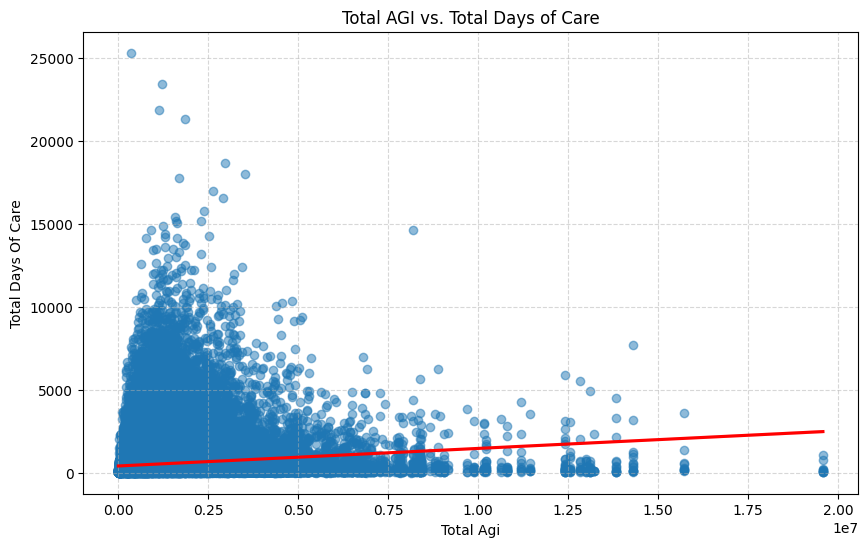

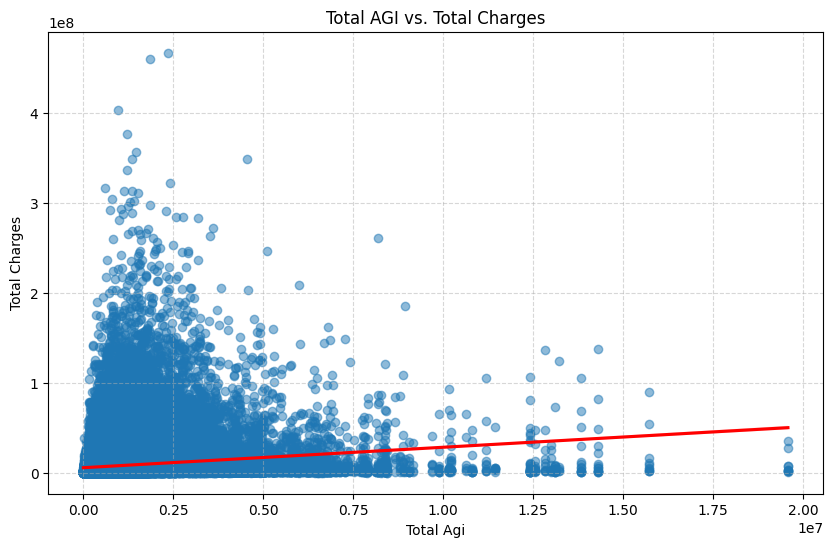

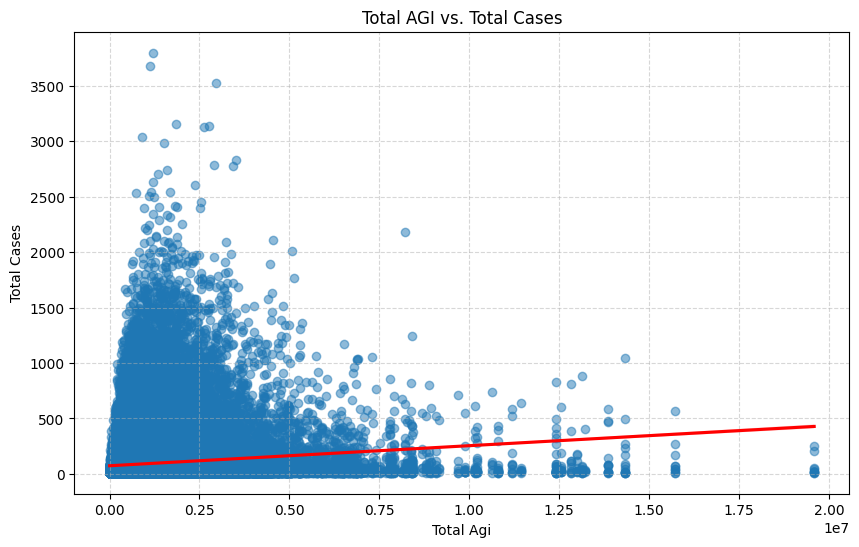

In [152]:
# Call the function for each pair of variables
plot_regression('total_agi', 'total_days_of_care', health_serv_pract_merged , "Total AGI vs. Total Days of Care")
plot_regression('total_agi', 'total_charges', health_serv_pract_merged , "Total AGI vs. Total Charges")
plot_regression('total_agi', 'total_cases', health_serv_pract_merged , "Total AGI vs. Total Cases")

<div class="alert alert-info">
  <strong>There is a very week correlation between income, as derived from the IRS AGI data</strong><br>
    and care. However, we see a high concentration at low AGI values.
</div>

<div class="alert alert-info">
  <strong>
      A CDC data will be explored next</strong><br>
    It contains medicare patients and their primary care access
</div>

In [153]:
cdc_data = pd.read_csv('../data/adult23.csv')

In [154]:
cdc_data.head()

,URBRRL,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,LANGSPECR_A,LANGSOC_A,LANGDOC_A,LANGMED_A,LANGHM_A,PPSU,...,PROXYREL_A,PROXY_A,AVAIL_A,HHSTAT_A,INTV_MON,RECTYPE,IMPNUM_A,WTFA_A,HHX,POVRATTC_A
0,3,4,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,1,1,1,10,1,7371.139,H029691,1.01
1,4,8,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,1,1,1,10,1,3146.794,H028812,2.49
2,4,14,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,1,1,1,10,1,10807.558,H045277,6.73
3,4,10,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,1,1,1,10,1,4661.643,H021192,3.43
4,4,5,0,0,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,1,1,1,10,1,10929.554,H025576,1.27


In [155]:
cdc_data.shape

(29522, 647)

<div class="alert alert-info">
  <strong>Too many columns in this datase.</strong><br>
    We will drop uineneccssary columns, where data is the same across all row or toomany rows are missing data.<br>
    We will not impute any NaN at this state.<br>
    Since there are 647 columns, we want to reduce the df to less than 50.
</div>

In [156]:
# Identify columns where all values are the same
constant_columns = [col for col in cdc_data.columns if cdc_data[col].nunique() == 1]

# Print the constant columns
print("Columns with the same value in all rows:", constant_columns)

Columns with the same value in all rows: ['HHRESPSA_FLG', 'MAFLG_A', 'PRFLG_A', 'PRPLCOV1_C_A', 'PRPLCOV2_C_A', 'SRVY_YR', 'CHHDHP_A', 'HHSTAT_A', 'RECTYPE', 'IMPNUM_A']


In [157]:
# Drop columns with more than 50% NaN values
cdc_data_clean = cdc_data.dropna(axis=1, thresh=int(0.5 * len(cdc_data)))

# Drop rows where essential columns ('REGION', 'RACEALLP_A', 'HISPALLP_A') are NaN
cdc_data_clean = cdc_data_clean.dropna(subset=['REGION', 'RACEALLP_A', 'HISPALLP_A'])

# Identify and drop columns where all values are the same
constant_columns = [col for col in cdc_data_clean.columns if cdc_data_clean[col].nunique() == 1]
cdc_data_clean = cdc_data_clean.drop(columns=constant_columns)

# Drop high-cardinality columns (almost all unique values)
high_cardinality_threshold = 0.95 * len(cdc_data_clean)
high_card_cols = [col for col in cdc_data_clean.columns if cdc_data_clean[col].nunique() > high_cardinality_threshold]
cdc_data_clean = cdc_data_clean.drop(columns=high_card_cols)
print(f"Dropped {len(high_card_cols)} high-cardinality columns.")

# Drop duplicate columns (comparing actual data, not just names)
cdc_data_clean = cdc_data_clean.loc[:, ~cdc_data_clean.T.duplicated()]

# Identify true categorical columns (excluding numerical stored as object)
categorical_cols = []
for col in cdc_data_clean.columns:
    unique_values = cdc_data_clean[col].dropna().unique()
    num_unique = len(unique_values)

    # If dtype is object OR has very few unique values, consider it categorical
    if cdc_data_clean[col].dtype == 'object' or num_unique < 15:
        # Exclude columns that might be misclassified numbers
        if not all(str(val).replace('.', '', 1).isdigit() for val in unique_values):
            categorical_cols.append(col)

# Drop identified categorical columns
cdc_data_clean = cdc_data_clean.drop(columns=categorical_cols)
print(f"Dropped {len(categorical_cols)} categorical columns.")

# Identify columns to drop based on naming patterns
drop_patterns = ['_QRT', '_MON']  # Drop columns containing these substrings
drop_prefixes = ['LANG']          # Drop columns starting with these
drop_suffixes = ['_FLG', 'FLG_A'] # Drop columns ending with these (case-insensitive)

cols_to_drop = [
    col for col in cdc_data_clean.columns 
    if any(pattern in col for pattern in drop_patterns) or
       any(col.startswith(prefix) for prefix in drop_prefixes) or
       any(col.upper().endswith(suffix) for suffix in drop_suffixes)  # Case-insensitive check
]

# Drop columns matching the patterns
cdc_data_clean = cdc_data_clean.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns matching naming patterns.")

# Keep essential columns + 20 random columns
essential_columns = ['RACEALLP_A', 'HISPALLP_A', 'REGION', 'SEX_A','DISCRIM1_A', 'VIGIL1_A','USUALPL_A']
remaining_columns = [col for col in cdc_data_clean.columns if col not in essential_columns]

# Select a random 20 additional columns
random_columns = random.sample(remaining_columns, min(14, len(remaining_columns)))

# Keep only selected columns
columns_to_keep = essential_columns + random_columns
cdc_data_clean = cdc_data_clean[columns_to_keep]

# Final shape check
print(f"Kept {len(columns_to_keep)} columns: {columns_to_keep}")
print("New shape of the dataframe:", cdc_data_clean.shape)

Dropped 2 high-cardinality columns.
Dropped 0 categorical columns.
Dropped 7 columns matching naming patterns.
Kept 21 columns: ['RACEALLP_A', 'HISPALLP_A', 'REGION', 'SEX_A', 'DISCRIM1_A', 'VIGIL1_A', 'USUALPL_A', 'COLORECTEV_A', 'DEMENEV_A', 'WLK100_A', 'MEDICARE_A', 'LIVEHEP_A', 'HIKIND06_A', 'TRANSPOR_A', 'PRIVATE_A', 'PRDNCOV1_A', 'FITHEV1_A', 'HOUTENURE_A', 'MAXEDUCP_A', 'PAIFRQ3M_A', 'LSATIS4_A']
New shape of the dataframe: (29522, 21)


In [158]:
cdc_data_clean.head()

,RACEALLP_A,HISPALLP_A,REGION,SEX_A,DISCRIM1_A,VIGIL1_A,USUALPL_A,COLORECTEV_A,DEMENEV_A,WLK100_A,...,LIVEHEP_A,HIKIND06_A,TRANSPOR_A,PRIVATE_A,PRDNCOV1_A,FITHEV1_A,HOUTENURE_A,MAXEDUCP_A,PAIFRQ3M_A,LSATIS4_A
0,2,3,3,1,5,5,1,1.0,2,NaN,...,2.0,2,1,3,NaN,2.0,2,1.0,4,2
1,1,2,3,1,5,5,1,2.0,2,2.0,...,2.0,2,2,1,1.0,1.0,1,8.0,4,2
2,2,3,3,1,5,5,1,2.0,2,1.0,...,2.0,1,2,3,NaN,2.0,1,8.0,2,1
3,1,2,3,2,5,3,1,1.0,2,1.0,...,2.0,1,2,3,NaN,1.0,1,9.0,1,1
4,1,2,3,2,5,5,1,1.0,2,1.0,...,2.0,2,2,1,2.0,1.0,1,7.0,1,1


In [159]:
cdc_data_clean.shape

(29522, 21)

<div class="alert alert-info">
  <strong>It is now a much smaller df. We can come back for additional columns if needed.
</div>

In [160]:
cdc_data_clean['REGION'].head()

0    3
1    3
2    3
3    3
4    3
Name: REGION, dtype: int64

In [161]:
# Create a copy of the dataframe for processing
cdc_data_processed = cdc_data_clean.copy()

# Lowercase all column names
cdc_data_processed.columns = cdc_data_processed.columns.str.lower()

# Rename columns
cdc_data_processed.columns = cdc_data_processed.columns.str.replace('discrim1', 'discrimination')
cdc_data_processed.columns = cdc_data_processed.columns.str.replace('vigil1', 'vigilance')

# Drop the '_a' suffix from column names
cdc_data_processed.columns = cdc_data_processed.columns.str.replace('_a', '', regex=False)

# Add an underscore between string and integer for discrimination and vigilance columns
cdc_data_processed.columns = cdc_data_processed.columns.str.replace(r'(discrimination|vigilance)(\d)', r'\1_\2', regex=True)

cdc_data_processed['region'] = pd.to_numeric(cdc_data_processed['region'], errors='coerce')


# Display the first few rows of the modified dataframe
cdc_data_processed.tail()

,raceallp,hispallp,region,sex,discrimination,vigilance,usualpl,colorectev,demenev,wlk100,...,livehep,hikind06,transpor,private,prdncov1,fithev1,houtenure,maxeducp,paifrq3m,lsatis4
29517,1,2,4,2,4,5,1,2.0,2,2.0,...,2.0,2,1,1,2.0,2.0,1,5.0,4,2
29518,1,2,4,2,3,5,1,1.0,2,1.0,...,2.0,2,2,1,1.0,2.0,1,7.0,1,1
29519,1,2,4,1,5,5,1,1.0,2,2.0,...,2.0,2,2,3,NaN,2.0,1,8.0,4,2
29520,1,2,4,2,5,5,1,1.0,2,1.0,...,2.0,2,2,1,1.0,2.0,1,7.0,3,1
29521,1,2,4,2,5,5,1,1.0,2,1.0,...,2.0,2,2,3,NaN,2.0,1,8.0,4,1


In [162]:
cdc_data_processed['region'].head()

0    3
1    3
2    3
3    3
4    3
Name: region, dtype: int64

In [163]:
import gc
gc.collect()

39

In [164]:
health_serv_pract_merged.shape

(145411, 20)

In [165]:
cdc_data_processed.shape

(29522, 21)

In [166]:
# Save the dataframes to CSV files
cdc_data_processed.to_csv('../data/cdc_data_processed.csv', index=False)
health_serv_pract_merged.to_csv('../data/health_serv_pract_merged.csv', index=False)

print("Dataframes saved successfully!")

Dataframes saved successfully!


<div class="alert alert-block alert-info">The file was getting to big. I modified the samples to be a subset of original data.<br>
The above save was to start a second part of the notebook.<br>
By using a subset, I might be able to keep everything in this notebook</div>

<div class="alert alert-block alert-info">We need to reduce the size of the resulting df. <br>
We will randomly sample from the two dfs. </div>

In [167]:
health_data = health_serv_pract_merged

In [168]:
cdc_data_new = cdc_data_processed

In [169]:
# Randomly sample a fraction of the dataset
fraction = 0.15
health_sampled = health_data.sample(frac=fraction, random_state=1)
cdc_sampled = cdc_data_new.sample(frac=fraction, random_state=1)

print("Sampled health_data shape:", health_sampled.shape)
print("Sampled cdc_data shape:", cdc_sampled.shape)



Sampled health_data shape: (21812, 20)
Sampled cdc_data shape: (4428, 21)


In [170]:
del cdc_data_new

In [171]:
del health_data

In [172]:
health_cdc_data = process_data(health_sampled, cdc_sampled)

Unique regions in health_df after mapping: ['west' 'northeast' 'south' 'midwest']
Unique regions in cdc_df after mapping: ['midwest' 'south' 'west' 'northeast']
Unique regions in health_agg after mapping: ['midwest' 'northeast' 'south' 'west']
NaN values in region column before merge: 0
NaN values in merged dataframe: region                                                 0
state                                                  0
city                                                   0
total_days_of_care                                     0
total_charges                                          0
total_cases                                            0
min_medicare_pricing_for_new_patient                   0
max_medicare_pricing_for_new_patient                   0
mode_medicare_pricing_for_new_patient                  0
min_copay_for_new_patient                              0
max_copay_for_new_patient                              0
mode_copay_for_new_patient                           

<div class="alert alert-block alert-info">Instead of deleting health_cdc_data, we will keep a random 15% <br>
The plots will use this subset</div>

In [173]:
health_cdc_data.shape

(12439021, 40)

In [174]:
health_cdc_data = health_cdc_data.sample(frac=0.05, random_state=42).reset_index(drop=True)

In [175]:
health_cdc_data.shape

(621951, 40)

In [176]:
# Rename column in the dataframe
health_cdc_data.rename(columns={'usualpl': 'access','raceallp':'race','hispallp':'hispanic'}, inplace=True)

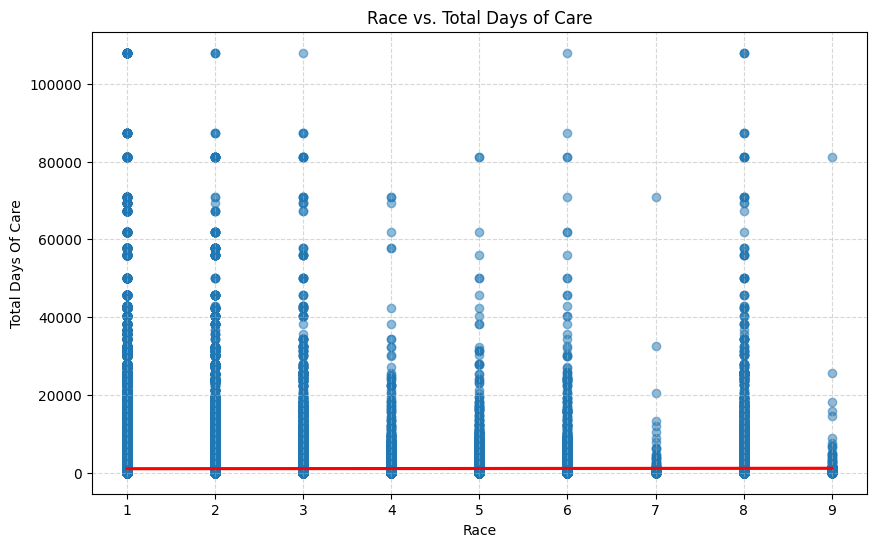

In [177]:
plot_regression('race', 'total_days_of_care', health_cdc_data , "Race vs. Total Days of Care")

<div style="background-color: rgba(128, 0, 128, 0.7); padding: 10px; color: white;"> Race definition:<br>
1 White<br> 
2 Black/African American <br>
3 Asian <br>
4 AIAN <br>
5 AIAN and any other group <br>
6 Other single and multiple races <br>
7 Refused <br>
8 Not Ascertained<br>
9 Don't know

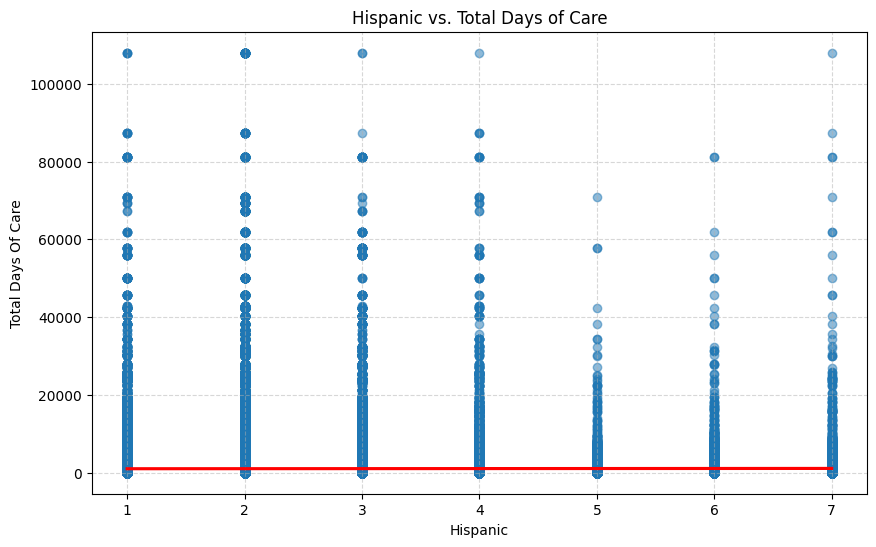

In [178]:
plot_regression('hispanic', 'total_days_of_care', health_cdc_data , "Hispanic vs. Total Days of Care")

<div style="background-color: rgba(128, 0, 128, 0.7); padding: 10px; color: white;"> Hispanic definition:<br>
1 Hispanic <br>
2 Non-Hispanic White only <br>
3 Non-Hispanic Black/African American only <br>
4 Non-Hispanic Asian only <br>
5 Non-Hispanic AIAN only <br>
6 Non-Hispanic AIAN and any other group <br>
7 Other single and multiple races <br>

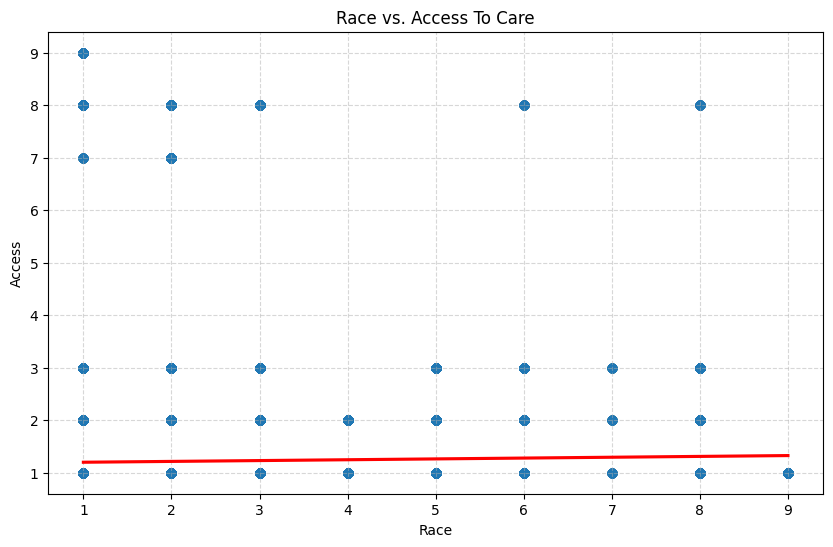

In [179]:
plot_regression('race', 'access' , health_cdc_data , "Race vs. Access To Care")

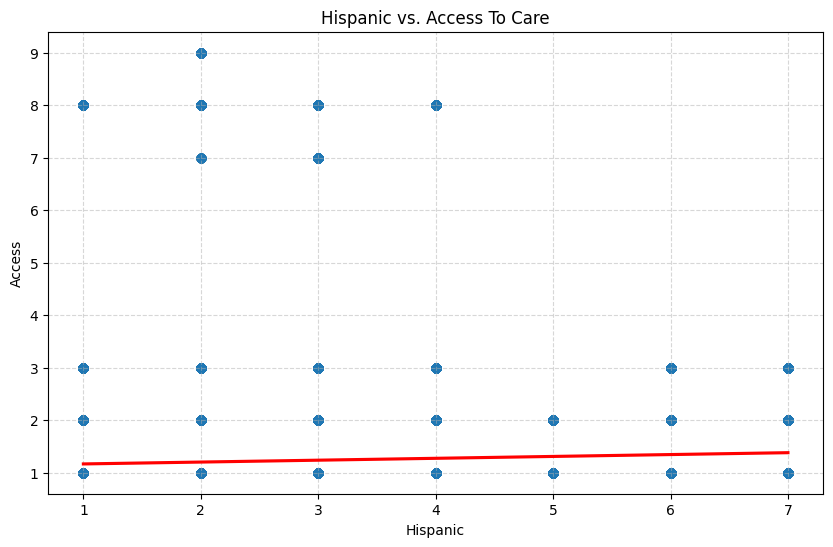

In [180]:
plot_regression('hispanic', 'access' , health_cdc_data , "Hispanic vs. Access To Care")

<div class="alert alert-block alert-info">There is an opportunity to improve plot_regression and pass it x and y labels.<br>
These plots have no significance<br>
No clear trend with a flat regression indicating a weak predictive ability</div>

<div class="alert alert-block alert-info">We see a lot of possibilities with the various data available in the CDC data. <br>
    The CDC data has a lot of information on race and access to healthcare. <br>
    <a href='https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2023/adult-codebook.pdf' style='color:orange;'>The data codebook</a> gives a lot of details.
</div>
    

<div class="alert alert-block alert-info">Time to scale the data. </div>

<div class="alert alert-block alert-info">Creating a state_summary df before scaling</div>

In [181]:
state_summary = health_cdc_data.groupby('state').agg(
    region=pd.NamedAgg(column='region', aggfunc='first'),  # Keeps the region for each state
    state_total_raceallp=pd.NamedAgg(column='race', aggfunc='sum'),
    state_avg_raceallp=pd.NamedAgg(column='race', aggfunc='mean'),
    
    state_total_hispallp=pd.NamedAgg(column='hispanic', aggfunc='sum'),
    state_avg_hispallp=pd.NamedAgg(column='hispanic', aggfunc='mean'),
    
    state_total_sex=pd.NamedAgg(column='sex', aggfunc='sum'),
    state_avg_sex=pd.NamedAgg(column='sex', aggfunc='mean'),
    
    state_total_access=pd.NamedAgg(column='access', aggfunc='sum'),
    state_avg_access=pd.NamedAgg(column='access', aggfunc='mean'),
    
    state_total_discrimination=pd.NamedAgg(column='discrimination', aggfunc='sum'),
    state_avg_discrimination=pd.NamedAgg(column='discrimination', aggfunc='mean'),
    
    state_total_vigilance=pd.NamedAgg(column='vigilance', aggfunc='sum'),
    state_avg_vigilance=pd.NamedAgg(column='vigilance', aggfunc='mean')
).reset_index()

# Move 'region' to be the first column
column_order = ['region'] + [col for col in state_summary.columns if col != 'region']
state_summary = state_summary[column_order]

state_summary = state_summary.loc[:, ~state_summary.columns.str.startswith("state_avg_")]

geo_sum_newind_reset['state'] = geo_sum_newind_reset['state'].str.lower()


state_summary = state_summary.merge(
    geo_sum_newind_reset[['state', 'occupation_per_100kcapita', 'occupation_per_100ksq_mile']],
    on='state',
    how='left'
)

In [182]:
state_summary.head()

,region,state,state_total_raceallp,state_total_hispallp,state_total_sex,state_total_access,state_total_discrimination,state_total_vigilance,occupation_per_100kcapita,occupation_per_100ksq_mile
0,south,alabama,33652,44371,30944,24685,84436,93439,0.734217,68.676078
1,west,alaska,5719,5994,4196,3101,11396,12631,4.374304,4.809253
2,west,arizona,15054,15060,10707,8105,29374,32711,0.508331,32.458988
3,south,arkansas,29302,38586,26658,21347,72535,81005,1.192920,67.695895
4,west,california,73449,74298,52331,39042,143116,159047,0.093642,22.603012


In [183]:
state_summary.shape

(51, 10)

In [184]:
state_summary.dtypes

region                         object
state                          object
state_total_raceallp            int64
state_total_hispallp            int64
state_total_sex                 int64
state_total_access              int64
state_total_discrimination      int64
state_total_vigilance           int64
occupation_per_100kcapita     float64
occupation_per_100ksq_mile    float64
dtype: object

<div class="alert alert-block alert-info">We only want numeric features to scale the data</div>

In [185]:
#Create a new dataframe, `state_summary_scale` from `state_summary` whilst setting the index to 'state'
state_summary_scale = state_summary.set_index('state')
#Save the state labels (using the index attribute of `state_summary_scale`) into the variable 'state_summary_index'
state_summary_index = state_summary_scale.index
#Save the column names (using the `columns` attribute) of `state_summary_scale` into the variable 'state_summary_columns'
state_summary_columns = state_summary_scale.columns
state_summary_scale.head()

,region,state_total_raceallp,state_total_hispallp,state_total_sex,state_total_access,state_total_discrimination,state_total_vigilance,occupation_per_100kcapita,occupation_per_100ksq_mile
state,,,,,,,,,
alabama,south,33652,44371,30944,24685,84436,93439,0.734217,68.676078
alaska,west,5719,5994,4196,3101,11396,12631,4.374304,4.809253
arizona,west,15054,15060,10707,8105,29374,32711,0.508331,32.458988
arkansas,south,29302,38586,26658,21347,72535,81005,1.192920,67.695895
california,west,73449,74298,52331,39042,143116,159047,0.093642,22.603012


<div class="alert alert-block alert-info">Using sklearn's StandardScaler to scale the data</div>

In [186]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (excluding 'region')
numerical_cols = state_summary_scale.columns.difference(['region'])

# Initialize the scaler
scaler = StandardScaler()

# Scale only the numerical columns
state_summary_scale[numerical_cols] = scaler.fit_transform(state_summary_scale[numerical_cols])

# Verify the transformation
state_summary_scale.head()

,region,state_total_raceallp,state_total_hispallp,state_total_sex,state_total_access,state_total_discrimination,state_total_vigilance,occupation_per_100kcapita,occupation_per_100ksq_mile
state,,,,,,,,,
alabama,south,0.814512,0.839669,0.823959,0.864349,0.829051,0.813769,-0.513102,-0.158170
alaska,west,-0.898043,-1.000810,-1.011395,-1.015352,-1.008666,-1.013746,2.007386,-0.168347
arizona,west,-0.325720,-0.566024,-0.564633,-0.579565,-0.556332,-0.559626,-0.669511,-0.163941
arkansas,south,0.547816,0.562232,0.529868,0.573650,0.529617,0.532568,-0.195484,-0.158326
california,west,3.254441,2.274903,2.291459,2.114667,2.305465,2.297529,-0.956652,-0.165511


<div class="alert alert-block alert-info">Let's verify the scaling. <br>
We will check the mean of the scaled features<br>
We will also check the standard deviation
</div>

In [187]:
# Set 'state' and 'region' as multi-index
state_summary_scaled_df = state_summary_scale.set_index('region', append=True)

#Call state_summary_scaled_df's mean() method
state_summary_scaled_df.mean()

state_total_raceallp          1.044916e-16
state_total_hispallp         -8.707632e-18
state_total_sex              -6.966105e-17
state_total_access            0.000000e+00
state_total_discrimination   -5.659961e-17
state_total_vigilance        -8.707632e-18
occupation_per_100kcapita    -2.176908e-16
occupation_per_100ksq_mile   -4.027280e-17
dtype: float64

In [188]:
#Call state_summary_scaled_df's std() method
state_summary_scaled_df.std()

state_total_raceallp          1.00995
state_total_hispallp          1.00995
state_total_sex               1.00995
state_total_access            1.00995
state_total_discrimination    1.00995
state_total_vigilance         1.00995
occupation_per_100kcapita     1.00995
occupation_per_100ksq_mile    1.00995
dtype: float64

<div class="alert alert-block alert-info">The mean is pretty much zero across all features<br>
    The standard deviation results are close enough to one.<br> But to double check we can set the estimate to biased instead of the default best</div>

In [189]:
#Call state_summary_scaled_df's std() method
state_summary_scaled_df.std(ddof=0)

state_total_raceallp          1.0
state_total_hispallp          1.0
state_total_sex               1.0
state_total_access            1.0
state_total_discrimination    1.0
state_total_vigilance         1.0
occupation_per_100kcapita     1.0
occupation_per_100ksq_mile    1.0
dtype: float64

<div class="alert alert-block alert-info">We have what we need, 1 standard deviation for all features.</div>

<div class="alert alert-block alert-info">Let's find dfs in memory and del the ones we don't need<br>
This was challenging. The suggestion is to go through the entire notebook and do this manually. Some dfs were needed for further work.<br>
After discussing with Govind, there are ways to optimize this notebook<br>
However, that is out of scope for this capstone.</div>

<div class="alert alert-block alert-info">We will fit the PCA transformation using the scaled data<br>
We will then plot the cummulative variance ratio with number of components

</div>

In [190]:
state_summary_scale.head()

,region,state_total_raceallp,state_total_hispallp,state_total_sex,state_total_access,state_total_discrimination,state_total_vigilance,occupation_per_100kcapita,occupation_per_100ksq_mile
state,,,,,,,,,
alabama,south,0.814512,0.839669,0.823959,0.864349,0.829051,0.813769,-0.513102,-0.158170
alaska,west,-0.898043,-1.000810,-1.011395,-1.015352,-1.008666,-1.013746,2.007386,-0.168347
arizona,west,-0.325720,-0.566024,-0.564633,-0.579565,-0.556332,-0.559626,-0.669511,-0.163941
arkansas,south,0.547816,0.562232,0.529868,0.573650,0.529617,0.532568,-0.195484,-0.158326
california,west,3.254441,2.274903,2.291459,2.114667,2.305465,2.297529,-0.956652,-0.165511


<div class="alert alert-block alert-info">We will drop avg columns as the total is what we will focus on. 

</div>

In [191]:
state_summary_scale = state_summary_scale.loc[:, ~state_summary_scale.columns.str.startswith("state_avg_")]

In [192]:
# Set 'state' and 'region' as multi-index
# Ensure 'region' is still a column before setting multi-index
if 'region' in state_summary_scale.columns:
    state_summary_scale = state_summary_scale.set_index('region', append=True)
    
state_pca = PCA().fit(state_summary_scale)

In [193]:
state_summary_scale.head()

,,state_total_raceallp,state_total_hispallp,state_total_sex,state_total_access,state_total_discrimination,state_total_vigilance,occupation_per_100kcapita,occupation_per_100ksq_mile
state,region,,,,,,,,
alabama,south,0.814512,0.839669,0.823959,0.864349,0.829051,0.813769,-0.513102,-0.158170
alaska,west,-0.898043,-1.000810,-1.011395,-1.015352,-1.008666,-1.013746,2.007386,-0.168347
arizona,west,-0.325720,-0.566024,-0.564633,-0.579565,-0.556332,-0.559626,-0.669511,-0.163941
arkansas,south,0.547816,0.562232,0.529868,0.573650,0.529617,0.532568,-0.195484,-0.158326
california,west,3.254441,2.274903,2.291459,2.114667,2.305465,2.297529,-0.956652,-0.165511


<div class="alert alert-block alert-info">Plot the cumulative variance ratio with number of components.

</div>

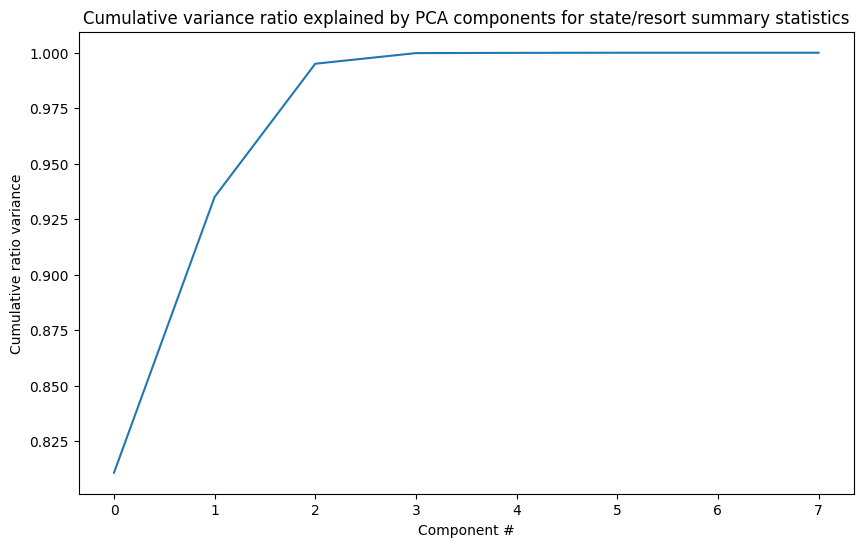

In [194]:
#Call the `cumsum()` method on the 'explained_variance_ratio_' attribute of `state_pca` and
#create a line plot to visualize the cumulative explained variance ratio with number of components
#Set the xlabel to 'Component #', the ylabel to 'Cumulative ratio variance', and the
#title to 'Cumulative variance ratio explained by PCA components for state/resort summary statistics'
#Hint: remember the handy ';' at the end of the last plot call to suppress that untidy output
plt.subplots(figsize=(10, 6))
plt.plot(state_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for state/resort summary statistics');

<div class="alert alert-block alert-info">About 85% of the variance is accounted for by the first two components

</div>

<div class="alert alert-block alert-info">
   Apply the transformation to the data to obtain the derived features.

</div>

In [195]:
#Call `state_pca`'s `transform()` method, passing in `state_summary_scale` as its argument
state_pca_x = state_pca.transform(state_summary_scale)

In [196]:
state_pca_x.shape

(51, 8)

<div class="alert alert-block alert-info">
    Plot the first two derived features (the first two principle components) and label each point with the name of the state.

</div>

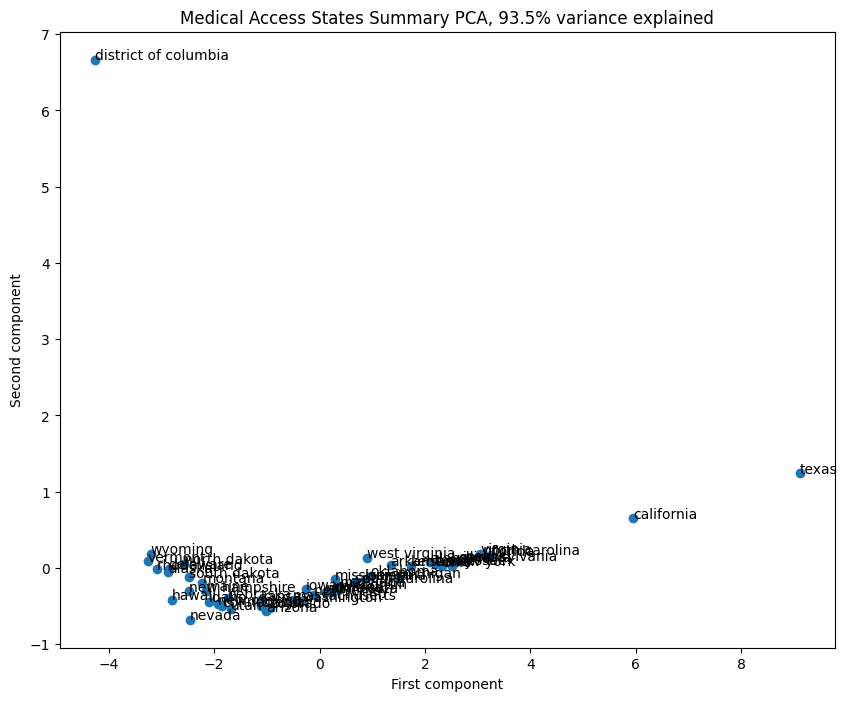

In [197]:
x = state_pca_x[:, 0]
y = state_pca_x[:, 1]
state = state_summary_index
pc_var = 100 * state_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Medical Access States Summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))

In [198]:
#Calculate the average 'access' by state
state_avg_access = health_cdc_data.groupby('state')['race'].mean()
state_avg_access.head()

state
alabama       1.688510
alaska        2.150809
arizona       2.188718
arkansas      1.697486
california    2.194210
Name: race, dtype: float64

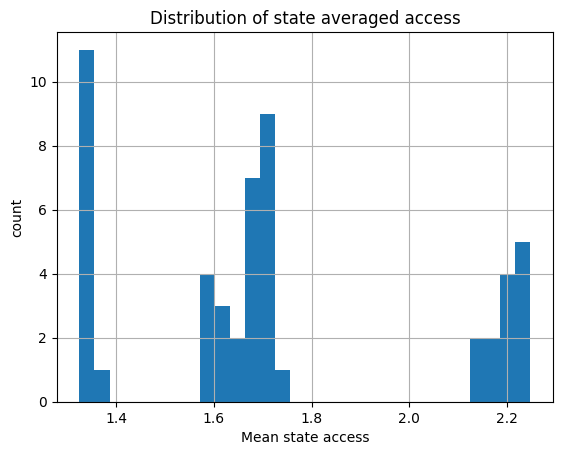

In [199]:
state_avg_access.hist(bins=30)
plt.title('Distribution of state averaged access')
plt.xlabel('Mean state access')
plt.ylabel('count');

In [200]:
#Create a dataframe containing the values of the first two PCA components
#Call these 'PC1' and 'PC2', respectively and set the dataframe index to `state_summary_index`
pca_df = pd.DataFrame({'PC1': state_pca_x[:, 0], 'PC2': state_pca_x[:, 1]}, index=state_summary_index)
pca_df.head()

,PC1,PC2
state,,
alabama,2.102443,0.076283
alaska,-2.869273,-0.053225
arizona,-1.022293,-0.563664
arkansas,1.346605,0.036864
california,5.942684,0.653711


<div class="alert alert-block alert-info">State is now the single index<br>
    We are going to ignore region for now.

</div>

In [201]:
# our average state prices also have state as an index
state_avg_access.head()

state
alabama       1.688510
alaska        2.150809
arizona       2.188718
arkansas      1.697486
california    2.194210
Name: race, dtype: float64

In [202]:
# we can also cast it to a dataframe using Series' to_frame() method:
state_avg_access.to_frame().head()

,race
state,
alabama,1.688510
alaska,2.150809
arizona,2.188718
arkansas,1.697486
california,2.194210


In [203]:
pca_df.head()

,PC1,PC2
state,,
alabama,2.102443,0.076283
alaska,-2.869273,-0.053225
arizona,-1.022293,-0.563664
arkansas,1.346605,0.036864
california,5.942684,0.653711


<div class="alert alert-block alert-info">We will concatenate both parts on axis 1 

</div>

In [204]:
#Use pd.concat to concatenate `pca_df` and `state_avg_price` along axis 1
# remember, pd.concat will align on index
pca_df = pd.concat([pca_df, state_avg_access], axis=1)
pca_df.head()

,PC1,PC2,race
state,,,
alabama,2.102443,0.076283,1.688510
alaska,-2.869273,-0.053225,2.150809
arizona,-1.022293,-0.563664,2.188718
arkansas,1.346605,0.036864,1.697486
california,5.942684,0.653711,2.194210


In [205]:
print(pca_df['race'].shape)  # Should output (n,) not (n,1)
print(type(pca_df['race']))

(51,)
<class 'pandas.core.series.Series'>


In [206]:
pca_df['Quartile'] = pd.qcut(pca_df.race, q=4, precision=1)
pca_df.head()

,PC1,PC2,race,Quartile
state,,,,
alabama,2.102443,0.076283,1.688510,"(1.7, 1.9]"
alaska,-2.869273,-0.053225,2.150809,"(1.9, 2.2]"
arizona,-1.022293,-0.563664,2.188718,"(1.9, 2.2]"
arkansas,1.346605,0.036864,1.697486,"(1.7, 1.9]"
california,5.942684,0.653711,2.194210,"(1.9, 2.2]"


In [207]:
# Quartile is a new data type: category
# This will affect how we handle it later on
pca_df.dtypes

PC1          float64
PC2          float64
race         float64
Quartile    category
dtype: object

In [208]:
pca_df[pca_df.isnull().any(axis=1)]

,PC1,PC2,race,Quartile
state,,,,


<div class="alert alert-block alert-info">
   No missing value

</div>

<div class="alert alert-block alert-info">
  Let's create a scatterplot<br>
    We will iterate through each Quartile and ploting points in the same quartile group as 1.<br>
    The points will be coloured by quartile and size by access.

</div>

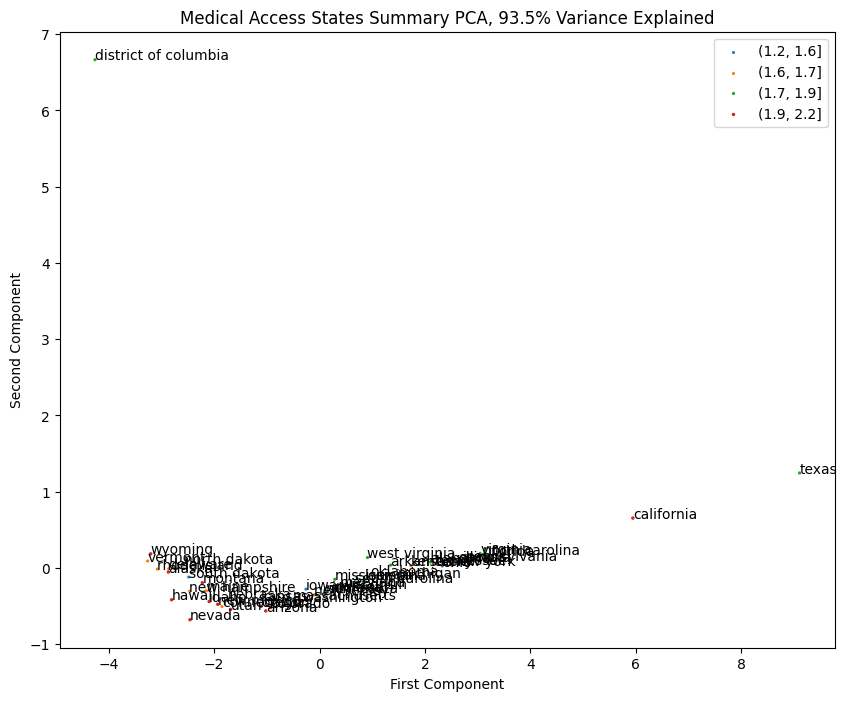

In [209]:
x = pca_df.PC1
y = pca_df.PC2
race = pca_df.race
quartiles = pca_df.Quartile
state = pca_df.index
pc_var = 100 * state_pca.explained_variance_ratio_.cumsum()[1]
plot_pca_scatter(x, y, quartiles, race, state, pc_var,'Medical Access States Summary PCA')

<div class="alert alert-block alert-info">
 Distribution is still the same as before and the average access is similar across all states.

</div>

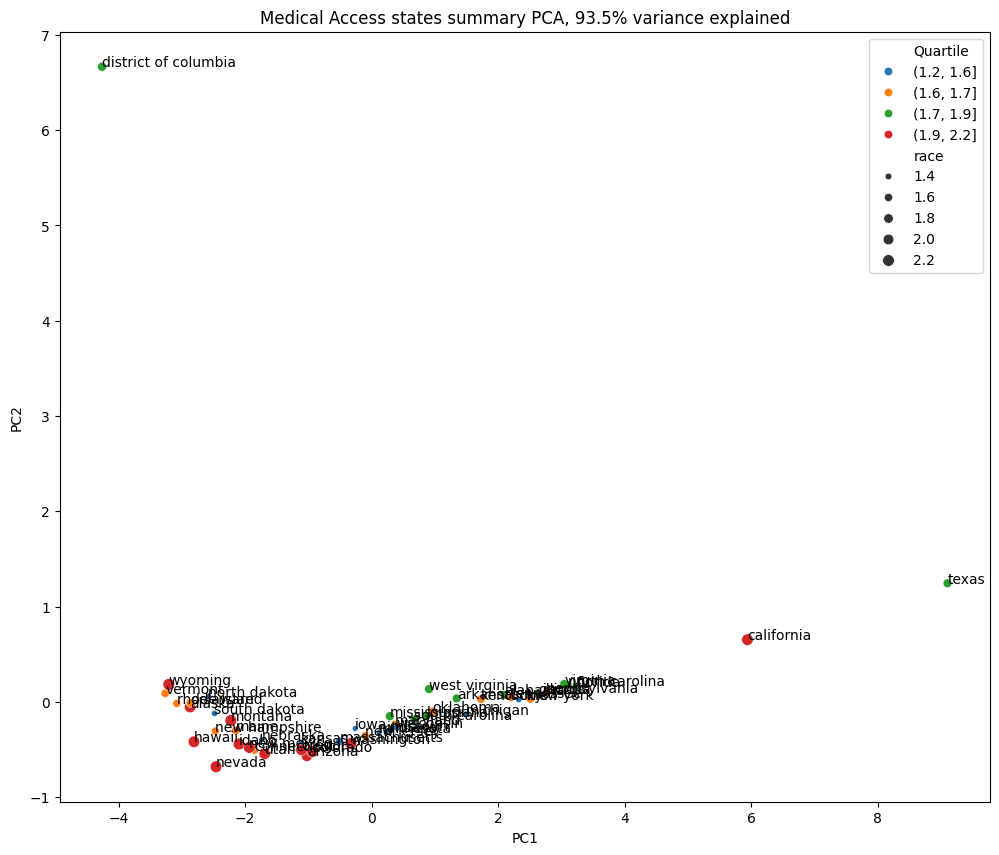

In [210]:
#Create a seaborn scatterplot by calling `sns.scatterplot`
#Specify the dataframe pca_df as the source of the data,
#specify 'PC1' for x and 'PC2' for y,
#specify 'race' for the pointsize (scatterplot's `size` argument),
#specify 'Quartile' for `hue`
#specify pca_df.Quartile.cat.categories for `hue_order` - what happens with/without this?
x = pca_df.PC1
y = pca_df.PC2
state = pca_df.index
plt.subplots(figsize=(12, 10))
# Note the argument below to make sure we get the colours in the ascending
# order we intuitively expect!
sns.scatterplot(x='PC1', y='PC2', size='race', hue='Quartile', 
                hue_order=pca_df.Quartile.cat.categories, data=pca_df)
#and we can still annotate with the state labels
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))   
plt.title(f'Medical Access states summary PCA, {pc_var:.1f}% variance explained');

<div class="alert alert-block alert-info">
Seaborn gives us a better visual
</div>

In [211]:
state_summary_columns

Index(['region', 'state_total_raceallp', 'state_total_hispallp',
       'state_total_sex', 'state_total_access', 'state_total_discrimination',
       'state_total_vigilance', 'occupation_per_100kcapita',
       'occupation_per_100ksq_mile'],
      dtype='object')

In [212]:
# Create a list of numerical columns by excluding 'region'
state_summary_num_cols = [col for col in state_summary_columns if col != 'region']

pd.DataFrame(state_pca.components_, columns=state_summary_num_cols)

,state_total_raceallp,state_total_hispallp,state_total_sex,state_total_access,state_total_discrimination,state_total_vigilance,occupation_per_100kcapita,occupation_per_100ksq_mile
0,0.383537,0.390522,0.390572,0.390163,0.390647,0.390644,-0.283722,-0.099558
1,0.079535,0.073086,0.070186,0.073300,0.071636,0.070247,0.268785,0.946426
2,0.129793,0.096541,0.088779,0.095890,0.092560,0.088695,0.919764,-0.307175
3,0.907213,-0.151152,-0.202223,-0.247026,-0.132330,-0.182931,-0.034901,0.003067
4,0.037297,0.225898,-0.393701,0.747997,-0.170551,-0.451576,-0.008411,-0.000499
5,-0.025975,-0.392888,-0.548547,0.091715,0.713750,0.161892,0.000795,-0.000167
6,-0.064233,0.777432,-0.408580,-0.435937,0.178914,-0.049832,-0.000905,-0.000162
7,0.022385,0.013866,-0.413412,0.119294,-0.495629,0.754002,0.000024,0.000011


In [213]:
health_cdc_data.dtypes

region                                            object
state                                             object
city                                              object
total_days_of_care                               float32
total_charges                                    float32
total_cases                                      float16
min_medicare_pricing_for_new_patient             float16
max_medicare_pricing_for_new_patient             float16
mode_medicare_pricing_for_new_patient            float16
min_copay_for_new_patient                        float16
max_copay_for_new_patient                        float16
mode_copay_for_new_patient                       float16
min_medicare_pricing_for_established_patient     float16
max_medicare_pricing_for_established_patient     float16
mode_medicare_pricing_for_established_patient    float16
min_copay_for_established_patient                float16
max_copay_for_established_patient                float16
mode_copay_for_established_pati

In [214]:
for col in health_cdc_data.select_dtypes(include=['int8', 'float16']).columns:
    health_cdc_data[col] = health_cdc_data[col].astype('float32')


In [215]:
health_cdc_data.head()

,region,state,city,total_days_of_care,total_charges,total_cases,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,...,livehep,hikind06,transpor,private,prdncov1,fithev1,houtenure,maxeducp,paifrq3m,lsatis4
0,south,south carolina,Sumter,16460.0,131894848.0,3156.0,482.25000,1475.000,748.5000,120.562500,...,2.0,2.0,2.0,1.0,2.0,NaN,2.0,10.0,2.0,1.0
1,south,texas,Huffman,527.0,7650966.0,72.0,174.75000,531.000,271.2500,43.687500,...,2.0,2.0,1.0,3.0,NaN,1.0,2.0,5.0,4.0,2.0
2,south,oklahoma,Oktaha,220.0,2020002.0,58.0,53.00000,162.625,82.4375,13.250000,...,2.0,2.0,2.0,1.0,2.0,2.0,1.0,9.0,1.0,1.0
3,midwest,minnesota,Zumbrota,49.0,321551.0,13.0,56.00000,168.250,85.8125,14.000000,...,2.0,2.0,2.0,1.0,2.0,1.0,1.0,7.0,2.0,1.0
4,south,texas,Hubbard,242.0,2751082.0,50.0,54.84375,166.875,84.9375,13.710938,...,2.0,2.0,2.0,3.0,NaN,2.0,1.0,4.0,3.0,2.0


In [216]:
# DataFrame's merge method provides SQL-like joins
# here 'state' and region are columns (not an index)
common_cols = ['region','state']
health_cdc_data = merge_dataframes(health_cdc_data, state_summary,common_cols,how='left')
health_cdc_data.head()

,region,state,city,total_days_of_care,total_charges,total_cases,min_medicare_pricing_for_new_patient,max_medicare_pricing_for_new_patient,mode_medicare_pricing_for_new_patient,min_copay_for_new_patient,...,paifrq3m,lsatis4,state_total_raceallp,state_total_hispallp,state_total_sex,state_total_access,state_total_discrimination,state_total_vigilance,occupation_per_100kcapita,occupation_per_100ksq_mile
0,south,south carolina,Sumter,16460.0,131894848.0,3156.0,482.25000,1475.000,748.5000,120.562500,...,2.0,1.0,24113,31606,22039,17397,59980,66628,0.718626,115.552780
1,south,texas,Huffman,527.0,7650966.0,72.0,174.75000,531.000,271.2500,43.687500,...,4.0,2.0,80927,106227,73745,58732,201882,224134,0.127604,13.775335
2,south,oklahoma,Oktaha,220.0,2020002.0,58.0,53.00000,162.625,82.4375,13.250000,...,1.0,1.0,26110,34405,24132,19069,65747,72976,0.909787,51.502883
3,midwest,minnesota,Zumbrota,49.0,321551.0,13.0,56.00000,168.250,85.8125,14.000000,...,2.0,1.0,16636,27092,19439,14904,51203,58673,0.656071,42.560044
4,south,texas,Hubbard,242.0,2751082.0,50.0,54.84375,166.875,84.9375,13.710938,...,3.0,2.0,80927,106227,73745,58732,201882,224134,0.127604,13.775335


In [217]:
health_cdc_data.fillna(0,inplace=True)

<div class="alert alert-block alert-info">
Is there a relationship between race, access, discrimination, vigilance, and sex?<br>
    Let's find ratios.
</div>

In [218]:
health_cdc_data['race_ratio'] = health_cdc_data.race / health_cdc_data.state_total_raceallp
health_cdc_data['access_ratio'] = health_cdc_data.access / health_cdc_data.state_total_access
health_cdc_data['discrimination_ratio'] = health_cdc_data.discrimination / health_cdc_data.state_total_discrimination
health_cdc_data['vigilance_ratio'] = health_cdc_data.vigilance / health_cdc_data.state_total_vigilance
health_cdc_data['sex_ratio'] = health_cdc_data.sex / health_cdc_data.state_total_sex

health_cdc_data.drop(columns=['state_total_access','state_total_discrimination','state_total_vigilance',
                              'state_total_sex','state_total_raceallp'], inplace = True)


<div style="background-color: rgba(128, 0, 128, 0.9); padding: 10px; color: white;">
<li>ratio of race to total state access
<li>ratio of discrimination to total state discrimination
<li>ratio of vigilance to total state vigilance
<li>ratio of sex to total state sex</li>
   
</div>

<div class="alert alert-block alert-info">
    Let's make sure we only use numeric features<br>
    To create a correlation heatmap
</div>

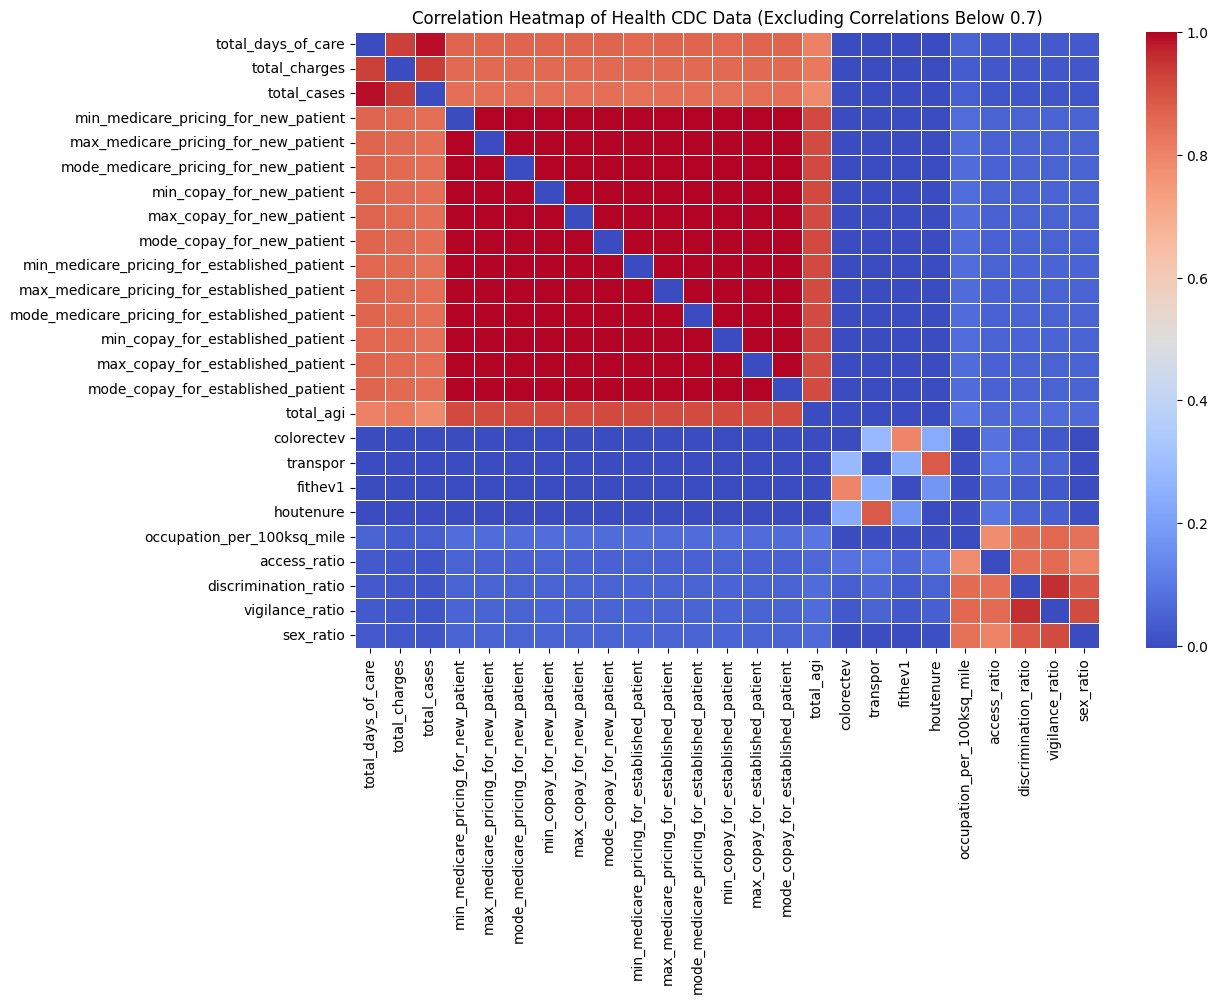

In [219]:
#Show a seaborn heatmap of correlations in health_cdc_data
health_cdc_data_numeric = health_cdc_data.select_dtypes(include=['float64', 'int64','float32'])

# Compute correlation matrix
corr_matrix = health_cdc_data_numeric.corr()

# Define threshold (adjust based on your needs)
threshold = 0.7  

# Remove self-correlation (set diagonal to 0)
np.fill_diagonal(corr_matrix.values, 0)

# Drop columns where the highest correlation is below the threshold
strong_corr_cols = corr_matrix.columns[(corr_matrix.abs().max() > threshold)]

filtered_corr = corr_matrix.loc[strong_corr_cols, strong_corr_cols]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title(f"Correlation Heatmap of Health CDC Data (Excluding Correlations Below {threshold})")
plt.show()


<div class="alert alert-block alert-info">
    Pricing and Copay are highly correlated. <br>
    Since they measure the same trend, we will drop the pricing columns. This will avoid potential multicollinearity<br>
    We saw earlier income does not impact days of care, charges and cases. It is weakly correlated to pricing.<br>
    Pricing isn't influenced by health behavior or marital status.<br>
    Access, discrimination, vigilance and sex show moderate correlation. Could social and demography influece access to healthcare<br>
    This one is important as it is the basis of this capstone. 
</div>

In [220]:
pricing_columns = [
    "min_medicare_pricing_for_new_patient",
    "max_medicare_pricing_for_new_patient",
    "mode_medicare_pricing_for_new_patient",
    "min_medicare_pricing_for_established_patient",
    "max_medicare_pricing_for_established_patient",
    "mode_medicare_pricing_for_established_patient"
]

health_cdc_data_cleaned = health_cdc_data.drop(columns=pricing_columns, errors='ignore')

print("Remaining Columns:", health_cdc_data_cleaned.columns.tolist())

Remaining Columns: ['region', 'state', 'city', 'total_days_of_care', 'total_charges', 'total_cases', 'min_copay_for_new_patient', 'max_copay_for_new_patient', 'mode_copay_for_new_patient', 'min_copay_for_established_patient', 'max_copay_for_established_patient', 'mode_copay_for_established_patient', 'total_agi', 'aggregation_level', 'race', 'hispanic', 'sex', 'discrimination', 'vigilance', 'access', 'colorectev', 'demenev', 'wlk100', 'medicare', 'livehep', 'hikind06', 'transpor', 'private', 'prdncov1', 'fithev1', 'houtenure', 'maxeducp', 'paifrq3m', 'lsatis4', 'state_total_hispallp', 'occupation_per_100kcapita', 'occupation_per_100ksq_mile', 'race_ratio', 'access_ratio', 'discrimination_ratio', 'vigilance_ratio', 'sex_ratio']


<div class="alert alert-block alert-info">
   Let's do scatterplot of numeric features against access
</div>

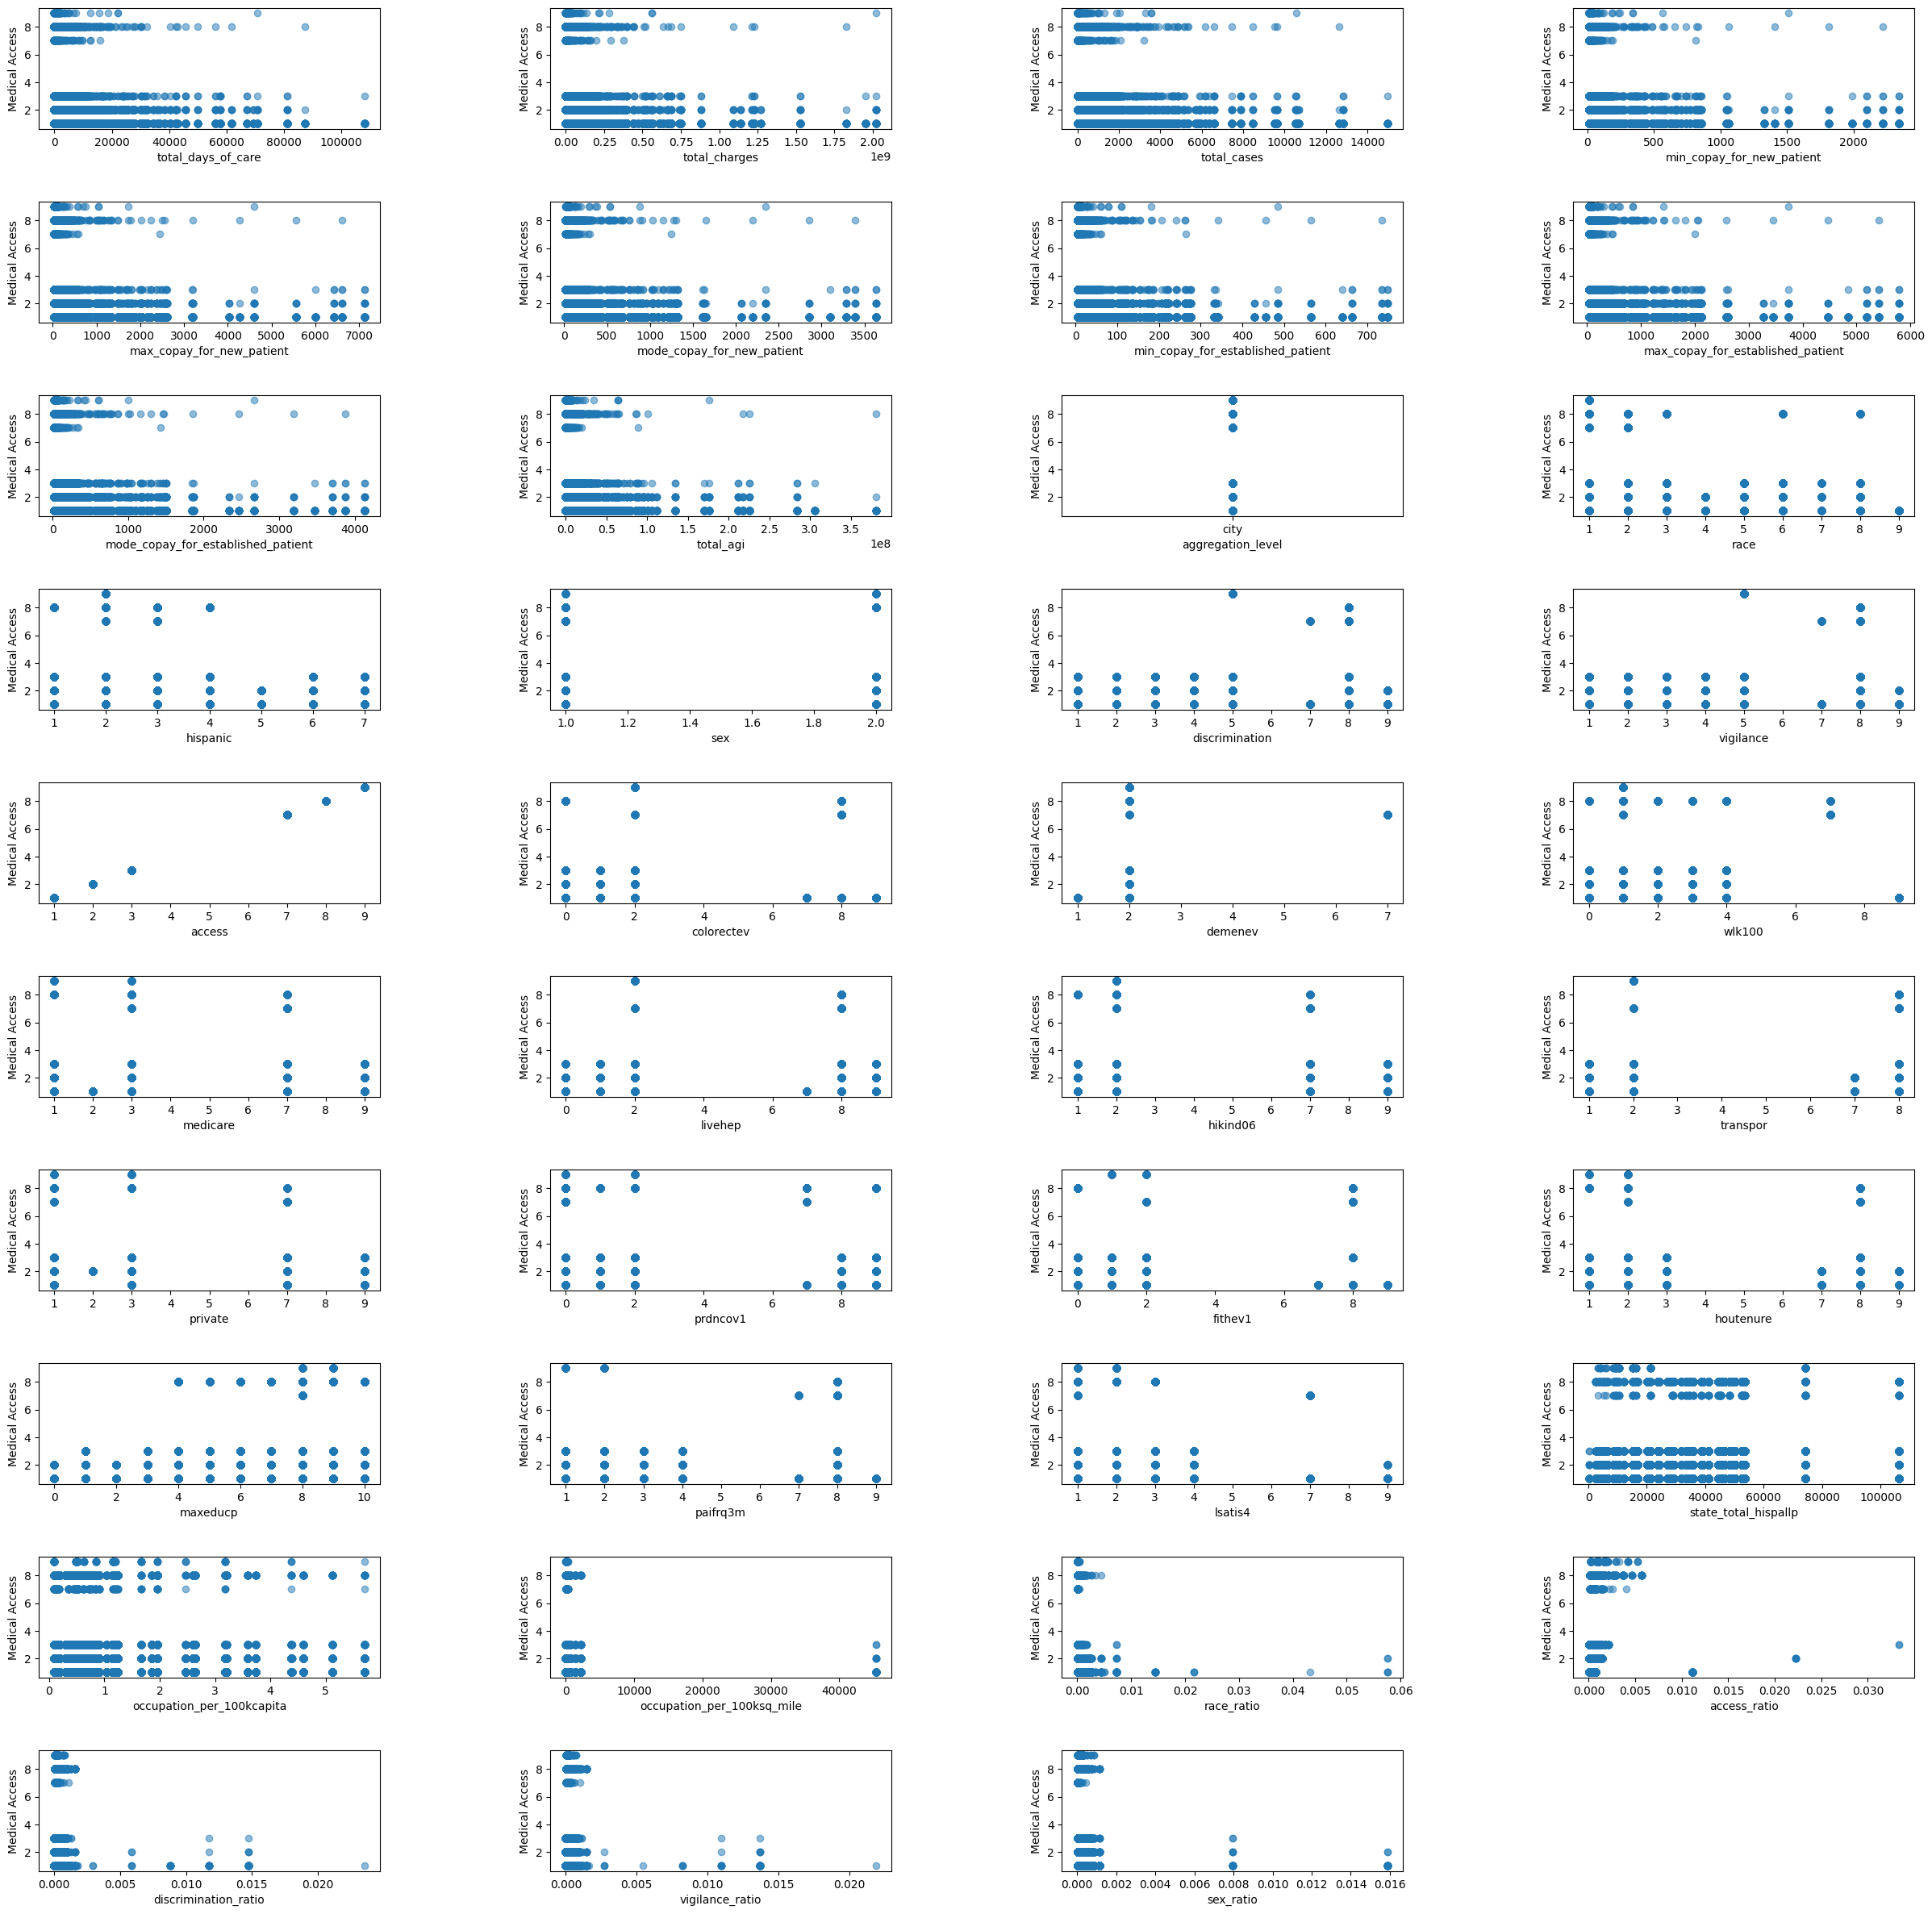

In [221]:
#Use a list comprehension to build a list of features from the columns of `health_cdc_data` that
#are _not_ any of 'state', or 'region'
features = list(health_cdc_data_cleaned.columns)
valid_features = [col for col in features if col in health_cdc_data_cleaned.columns and col not in ['region', 'state', 'city']]


scatterplots(health_cdc_data_cleaned,valid_features, ncol=4, figsize=(30, 30))

In [222]:
scatter_features = [col for col in health_cdc_data_cleaned.columns if col in ['discrimination_ratio', 'vigilance_ratio', 'sex_ratio']]

<div class="alert alert-block alert-info">
    Additional features to consider</div>

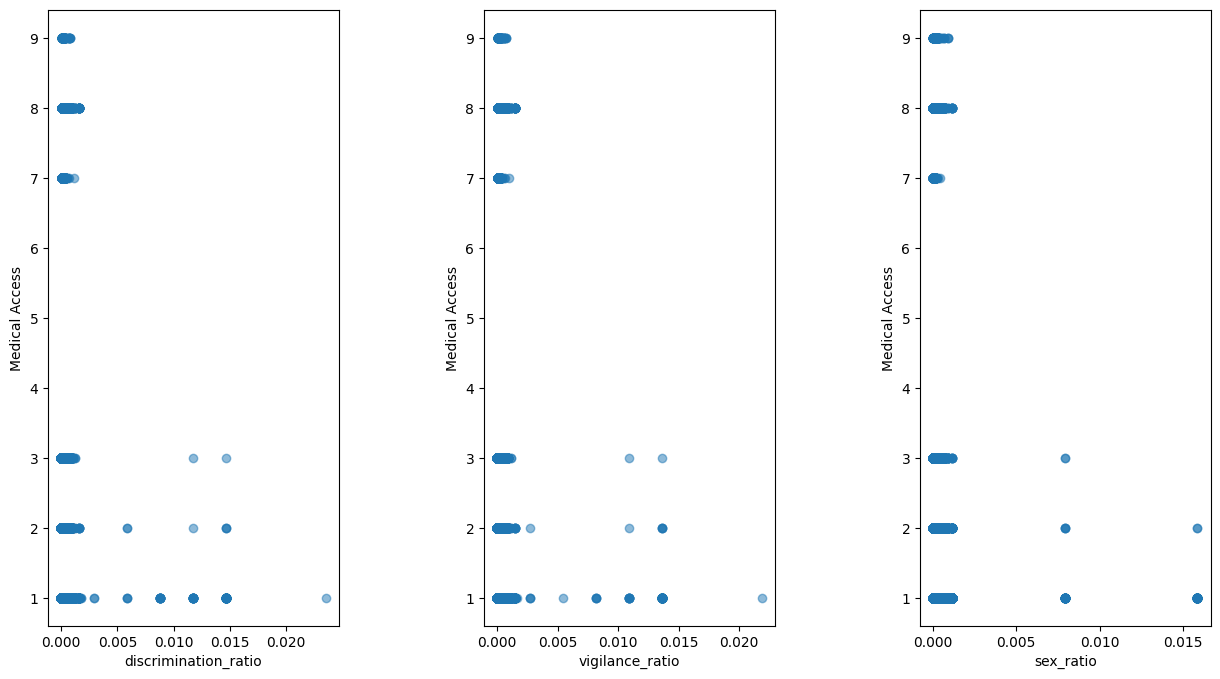

In [223]:
scatterplots(health_cdc_data_cleaned,scatter_features)

<div class="alert alert-block alert-info" align='center'>
    <h1>Summary<h1></div>

<div class="alert alert-block alert-info">
    After loading the occupation data, it was obvious that the data used was not adequate to address the hypothesis. Additional dat awas required. After exploring different publicly available data sets. I landed on CDC Data. In order to make all the existing data and the CDC data work together, merging with Zip Data was necessary. Some data only had zip while others only had state. After working the final dataframe, I discovered opportunities for efficiency. Some of which are not yet implemented at this phase of the capstone. <br><br>
   Many of the patterns discovered during the EDA did not lend to an obvious trend. When I finally plotted the correlation heatmap, some possibilities are starting to surface. <br><br>
    
During the PCA, I focused solely on numerical features. Scatter plots were not very helpful so far. One of th ebiggest learning during this phase is memory usage and storage efficiency. Govind, my mentor has highlighted a few opportunities of improvement. 
    </div>
    

In [ ]:
# Save the data 

datapath = '../data/health_cdc_data_EDA_features.csv'
health_cdc_data_cleaned.to_csv(datapath, index=False)

print("Dataframes saved successfully!")

#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")